In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import logit

from src.analysis.state_space import StateSpaceAnalysisSpec
from src.utils import concat_csv_with_indices

In [3]:
sns.set_context("paper", font_scale=1.5)

In [5]:
false_friends_path = "outputs/analogy/inputs/librispeech-train-clean-100/w2v2_pc/false_friends.csv"
state_space_path = "outputs/analogy/inputs/librispeech-train-clean-100/w2v2_pc/state_space_spec.h5"
most_common_allomorphs_path = "outputs/analogy/inputs/librispeech-train-clean-100/w2v2_pc/most_common_allomorphs.csv"
cross_instances_path = "outputs/analogy/inputs/librispeech-train-clean-100/w2v2_pc/all_cross_instances.parquet"
output_dir = "analogy_figures/pseudocausal"

In [6]:
# Grouping variables on experiment results dataframe to select a single run
run_groupers = ["base_model_name", "model_name", "equivalence"]

# plot_runs = [(f"w2v2_{i}", "ff_32", "word_broad_10frames_fixedlen25") for i in range(12)] + \
#             [(f"w2v2_{i}", "id", "id") for i in range(12)]
plot_runs = [("w2v2_pc_8", "discrim-rnn_32-pc-mAP1", "word_broad_10frames_fixedlen25"),]

main_plot_run = plot_runs[0]
# choose a vmin, vmax so that all heatmaps have the same color scale
main_plot_vmin, main_plot_vmax = 0.4, 0.9

plot_inflections = ["NNS", "VBZ", "VBD"]

## Load metadata

In [34]:
word_freq_df = pd.read_csv("data/WorldLex_Eng_US.Freq.2.txt", sep="\t", index_col="Word")
# compute weighted average frequency across domains
word_freq_df["BlogFreq_rel"] = word_freq_df.BlogFreq / word_freq_df.BlogFreq.sum()
word_freq_df["TwitterFreq_rel"] = word_freq_df.TwitterFreq / word_freq_df.TwitterFreq.sum()
word_freq_df["NewsFreq_rel"] = word_freq_df.NewsFreq / word_freq_df.NewsFreq.sum()
word_freq_df["Freq"] = word_freq_df[["BlogFreq_rel", "TwitterFreq_rel", "NewsFreq_rel"]].mean(axis=1) \
    * word_freq_df[["BlogFreq", "TwitterFreq", "NewsFreq"]].sum().mean()
word_freq_df["LogFreq"] = np.log10(word_freq_df.Freq)

In [8]:
false_friends_df = pd.read_csv(false_friends_path)

In [9]:
most_common_allomorphs = pd.read_csv(most_common_allomorphs_path)

In [10]:
all_cross_instances = pd.read_parquet(cross_instances_path)

## Load results

In [56]:
all_results = concat_csv_with_indices(
        "outputs/analogy_pc/runs/**/experiment_results.csv",
        [lambda p: p.parent.name, lambda p: p.parents[1].name,
            lambda p: p.parents[2].name],
        ["equivalence", "model_name", "base_model_name"]) \
    .droplevel(-1).reset_index()

/userdata/jgauthier/projects/ideal-word-representations/src/utils/__init__.py:38: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs = [reader(p, **kwargs) for p in paths]


In [57]:
all_id_results = concat_csv_with_indices(
        "outputs/analogy_pc/runs_id/**/experiment_results.csv",
        [lambda p: p.parent.name],
        ["base_model_name"]) \
    .droplevel(-1).reset_index()
all_id_results["model_name"] = "id"
all_id_results["equivalence"] = "id"

In [58]:
all_results = pd.concat([all_results, all_id_results], ignore_index=True) \
    .astype({"correct": bool})

In [59]:
all_results["group"] = all_results.group.apply(lambda x: eval(x) if not (isinstance(x, float) and np.isnan(x)) else None)
all_results = all_results.reset_index()

In [60]:
all_results

,index,equivalence,model_name,base_model_name,experiment,Unnamed: 1,group,from_equiv_label,to_equiv_label,base_from,...,inflection_from,inflection_to,predicted_label_idx,predicted_label,predicted_instance_idx,gt_label,gt_label_idx,gt_label_rank,gt_distance,correct
0,0,word_broad_10frames_fixedlen25,discrim-rnn_32-pc-mAP1,w2v2_pc_8,basic,0.0,"(NNS,)","('model', 'models')","('dog', 'dogs')",model,...,NNS,NNS,1789.0,dogs,41.0,dogs,1789.0,0.0,0.392839,True
1,1,word_broad_10frames_fixedlen25,discrim-rnn_32-pc-mAP1,w2v2_pc_8,basic,1.0,"(NNS,)","('shelf', 'shelves')","('boundary', 'boundaries')",shelf,...,NNS,NNS,3485.0,bounds,9.0,boundaries,4699.0,1.0,0.540625,False
2,2,word_broad_10frames_fixedlen25,discrim-rnn_32-pc-mAP1,w2v2_pc_8,basic,2.0,"(NNS,)","('principle', 'principles')","('row', 'rows')",principle,...,NNS,NNS,3324.0,road,94.0,rows,6582.0,16.0,1.008106,False
3,3,word_broad_10frames_fixedlen25,discrim-rnn_32-pc-mAP1,w2v2_pc_8,basic,3.0,"(NNS,)","('objection', 'objections')","('common', 'commons')",objection,...,NNS,NNS,810.0,comment,10.0,commons,13952.0,11.0,0.981209,False
4,4,word_broad_10frames_fixedlen25,discrim-rnn_32-pc-mAP1,w2v2_pc_8,basic,4.0,"(NNS,)","('platform', 'platforms')","('prospect', 'prospects')",platform,...,NNS,NNS,5437.0,prospects,1.0,prospects,5437.0,0.0,0.820173,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90113,90113,word_broad_10frames_fixedlen25,discrim-rnn_32-pc-mAP1,w2v2_pc_8,FC-T_IH D-from_VBD-T,995.0,None,"('camp', 'camped')","('rap', 'rapped')",camp,...,VBD,FC-T_IH D,19733.0,rapped,3.0,rapped,19733.0,0.0,0.810177,True
90114,90114,word_broad_10frames_fixedlen25,discrim-rnn_32-pc-mAP1,w2v2_pc_8,FC-T_IH D-from_VBD-T,996.0,None,"('induce', 'induced')","('plan', 'plant')",induce,...,VBD,FC-T_IH D,8218.0,planned,13.0,plant,4583.0,16.0,0.858657,False
90115,90115,word_broad_10frames_fixedlen25,discrim-rnn_32-pc-mAP1,w2v2_pc_8,FC-T_IH D-from_VBD-T,997.0,None,"('cease', 'ceased')","('learn', 'learnt')",cease,...,VBD,FC-T_IH D,3573.0,learned,42.0,learnt,9801.0,8.0,0.823222,False
90116,90116,word_broad_10frames_fixedlen25,discrim-rnn_32-pc-mAP1,w2v2_pc_8,FC-T_IH D-from_VBD-T,998.0,None,"('furnish', 'furnished')","('rap', 'rapped')",furnish,...,VBD,FC-T_IH D,3819.0,wrapped,0.0,rapped,19733.0,19.0,0.977668,False


### Layer-wise

In [30]:
plot_lw = all_results.query("experiment == 'regular'").copy()
plot_lw = plot_lw.groupby(run_groupers + ["group", "inflection_from"]).correct.mean()
plot_lw = plot_lw.reindex([(*plot_run, group, inflection_from)
                           for group in plot_lw.index.get_level_values("group").unique()
                           for inflection_from in plot_lw.index.get_level_values("inflection_from").unique()
                           for plot_run in plot_runs]).reset_index()
plot_lw["group0"] = plot_lw.group.apply(lambda x: x[0] if x is not None else None)
plot_lw["group1"] = plot_lw.group.apply(lambda x: x[1] if x is not None else None)
plot_lw["layer"] = plot_lw.base_model_name.str.extract(r"_(\d+)$").astype(int)

lw_random = plot_lw[plot_lw.group0 == "random"].groupby(["inflection_from", "layer"]).correct.mean().reset_index().dropna()

plot_lw = plot_lw[plot_lw.inflection_from.isin(plot_inflections)]
plot_lw = plot_lw[(plot_lw.group1 == True)]

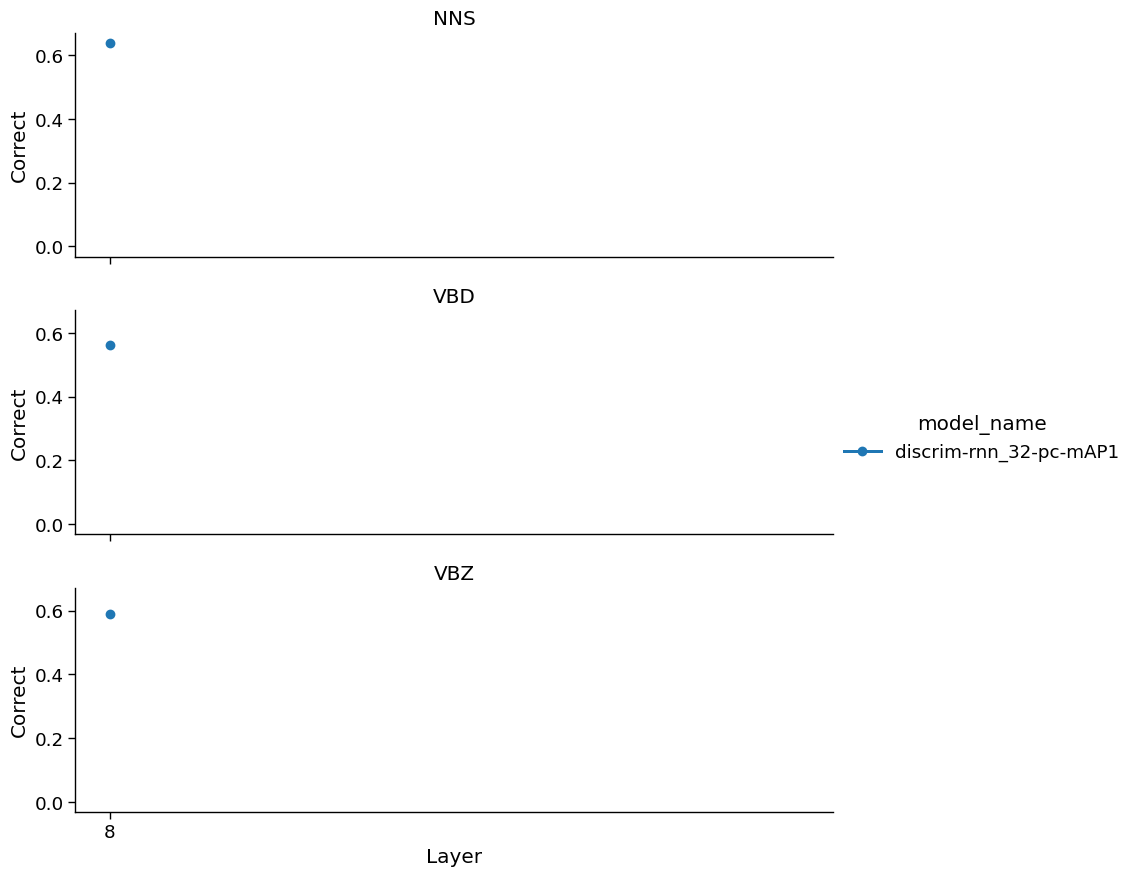

In [31]:
g = sns.catplot(data=plot_lw, x="layer", y="correct", hue="model_name", row="inflection_from",
                kind="point", height=3, aspect=3)

for ax, row_name in zip(g.axes.flat, g.row_names):
    sns.lineplot(data=lw_random,
                 x="layer", y="correct", ax=ax, color="gray", linestyle="--",
                 legend=None)
    ax.set_title(ax.get_title().split("=")[1].strip())
    ax.set_ylabel("Correct")
    if ax.get_xlabel() == "layer":
        ax.set_xlabel("Layer")

# g.figure.tight_layout()
g.figure.savefig(f"{output_dir}/layer_wise.pdf")

## Compute controlled NNVB results

In [35]:
all_nnvb_results = []

for run, run_results in all_results.groupby(run_groupers):
    run_results = run_results.set_index("experiment")
    nnvb_expts = run_results.index.unique()
    nnvb_expts = nnvb_expts[nnvb_expts.str.contains("unambiguous-")]

    for expt in nnvb_expts:
        inflection_from, allomorph_from, inflection_to, allomorph_to = \
            re.findall(r"unambiguous-(\w+)_([\w\s]+)_to_(\w+)_([\w\s]+)", expt)[0]
        expt_df = run_results.loc[expt].copy()

        num_seen_words = min(len(expt_df.base_from.unique()), len(expt_df.base_to.unique()))
        # DEV
        # if num_seen_words < 10:
        #     print(f"Skipping {expt} due to only {num_seen_words} seen words")
        #     continue

        expt_df["inflection_from"] = inflection_from
        expt_df["allomorph_from"] = allomorph_from
        expt_df["inflection_to"] = inflection_to
        expt_df["allomorph_to"] = allomorph_to

        all_nnvb_results.append(expt_df)

all_nnvb_results = pd.concat(all_nnvb_results)

all_nnvb_results["inflected_from"] = all_nnvb_results.from_equiv_label.apply(lambda x: eval(x)[1])
all_nnvb_results["inflected_to"] = all_nnvb_results.to_equiv_label.apply(lambda x: eval(x)[1])

all_nnvb_results = pd.merge(all_nnvb_results, word_freq_df.LogFreq.rename("from_base_freq"),
                            left_on="base_from", right_index=True)
all_nnvb_results = pd.merge(all_nnvb_results, word_freq_df.LogFreq.rename("from_inflected_freq"),
                            left_on="inflected_from", right_index=True)
all_nnvb_results = pd.merge(all_nnvb_results, word_freq_df.LogFreq.rename("to_base_freq"),
                              left_on="base_to", right_index=True)
all_nnvb_results = pd.merge(all_nnvb_results, word_freq_df.LogFreq.rename("to_inflected_freq"),
                            left_on="inflected_to", right_index=True)

all_nnvb_results["from_freq"] = all_nnvb_results[["from_base_freq", "from_inflected_freq"]].mean(axis=1)
all_nnvb_results["to_freq"] = all_nnvb_results[["to_base_freq", "to_inflected_freq"]].mean(axis=1)

_, frequency_bins = pd.qcut(pd.concat([all_nnvb_results.to_freq, all_nnvb_results.from_freq]), q=5, retbins=True)
all_nnvb_results["to_freq_bin"] = pd.cut(all_nnvb_results.to_freq, bins=frequency_bins, labels=[f"Q{i}" for i in range(1, 6)])
all_nnvb_results["from_freq_bin"] = pd.cut(all_nnvb_results.from_freq, bins=frequency_bins, labels=[f"Q{i}" for i in range(1, 6)])

In [64]:
def summarize_nnvb_run(rows):
    rows["source_label"] = rows.inflection_from + " " + rows.allomorph_from
    rows["target_label"] = rows.inflection_to + " " + rows.allomorph_to

    rows["transfer_label"] = rows.inflection_from + " -> " + rows.inflection_to
    rows["phon_label"] = rows.allomorph_from + " " + rows.allomorph_to

    # only retain cases where we have data in both transfer directions from source <-> target within inflection
    rows["complement_exists"] = rows.apply(lambda row: len(rows.query("source_label == @row.target_label and target_label == @row.source_label")), axis=1)
    rows = rows.query("complement_exists > 0").drop(columns=["complement_exists"])

    return rows

summary_groupers = ["inflection_from", "inflection_to", "allomorph_from", "allomorph_to"]
nnvb_results_summary = all_nnvb_results.groupby(run_groupers + summary_groupers) \
    .correct.agg(["count", "mean"]) \
    .query("count >= 0") \
    .reset_index(summary_groupers) \
    .groupby(run_groupers, group_keys=False) \
    .apply(summarize_nnvb_run) \
    .reset_index() \
    .astype({"mean": float})

nnvb_results_summary

,base_model_name,model_name,equivalence,inflection_from,inflection_to,allomorph_from,allomorph_to,count,mean,source_label,target_label,transfer_label,phon_label
0,w2v2_pc_8,discrim-rnn_32-pc-mAP1,word_broad_10frames_fixedlen25,NNS,NNS,IH Z,IH Z,1000,0.720000,NNS IH Z,NNS IH Z,NNS -> NNS,IH Z IH Z
1,w2v2_pc_8,discrim-rnn_32-pc-mAP1,word_broad_10frames_fixedlen25,NNS,NNS,IH Z,S,1000,0.566000,NNS IH Z,NNS S,NNS -> NNS,IH Z S
2,w2v2_pc_8,discrim-rnn_32-pc-mAP1,word_broad_10frames_fixedlen25,NNS,NNS,IH Z,Z,1000,0.706000,NNS IH Z,NNS Z,NNS -> NNS,IH Z Z
3,w2v2_pc_8,discrim-rnn_32-pc-mAP1,word_broad_10frames_fixedlen25,NNS,NNS,S,IH Z,1000,0.546000,NNS S,NNS IH Z,NNS -> NNS,S IH Z
4,w2v2_pc_8,discrim-rnn_32-pc-mAP1,word_broad_10frames_fixedlen25,NNS,NNS,S,S,1000,0.623000,NNS S,NNS S,NNS -> NNS,S S
5,w2v2_pc_8,discrim-rnn_32-pc-mAP1,word_broad_10frames_fixedlen25,NNS,NNS,S,Z,1000,0.705000,NNS S,NNS Z,NNS -> NNS,S Z
6,w2v2_pc_8,discrim-rnn_32-pc-mAP1,word_broad_10frames_fixedlen25,NNS,NNS,Z,IH Z,1000,0.548000,NNS Z,NNS IH Z,NNS -> NNS,Z IH Z
7,w2v2_pc_8,discrim-rnn_32-pc-mAP1,word_broad_10frames_fixedlen25,NNS,NNS,Z,S,1000,0.625000,NNS Z,NNS S,NNS -> NNS,Z S
8,w2v2_pc_8,discrim-rnn_32-pc-mAP1,word_broad_10frames_fixedlen25,NNS,NNS,Z,Z,1000,0.728000,NNS Z,NNS Z,NNS -> NNS,Z Z
9,w2v2_pc_8,discrim-rnn_32-pc-mAP1,word_broad_10frames_fixedlen25,NNS,VBZ,IH Z,IH Z,264,0.371212,NNS IH Z,VBZ IH Z,NNS -> VBZ,IH Z IH Z


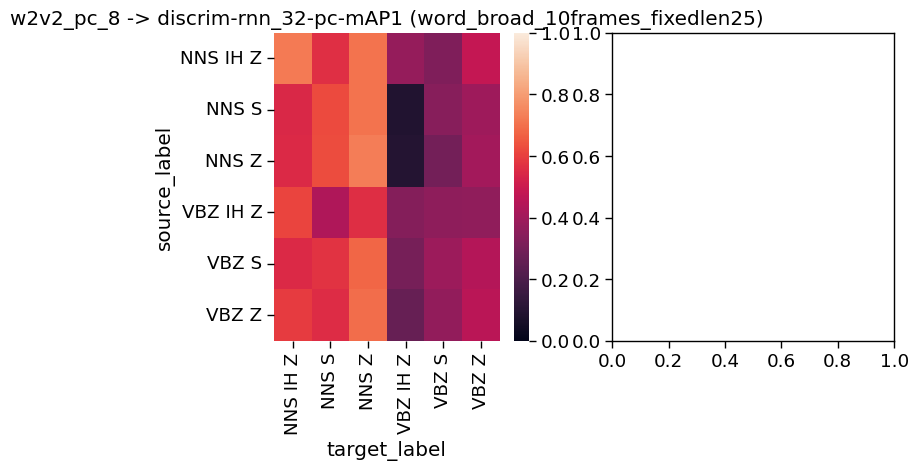

In [65]:
plot_results = []
for base_model_name, model_name, equivalence in plot_runs:
    results_i = nnvb_results_summary.query("base_model_name == @base_model_name and model_name == @model_name and equivalence == @equivalence")
    if len(results_i) > 0:
        plot_results.append(results_i)
num_plot_runs = len(plot_results)

ncols = 2
nrows = int(np.ceil(num_plot_runs / ncols))
f, axs = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4))

for ax, results_i in zip(axs.flat, plot_results):
    sns.heatmap(results_i.set_index(["source_label", "target_label"])["mean"].unstack(),
                vmin=0, vmax=1, ax=ax)
    key_row = results_i.iloc[0]
    ax.set_title(f"{key_row.base_model_name} -> {key_row.model_name} ({key_row.equivalence})")

### Focused plots

In [43]:
focus_base_model, focus_model, focus_equivalence = main_plot_run
foil_base_model, foil_model, foil_equivalence = "w2v2_8", "id", "id"

nnvb_focus = all_nnvb_results.query("base_model_name == @focus_base_model and model_name == @focus_model and equivalence == @focus_equivalence")
nnvb_foil = all_nnvb_results.query("base_model_name == @foil_base_model and model_name == @foil_model and equivalence == @foil_equivalence")
nnvb_focus["model_label"] = "Word"
nnvb_foil["model_label"] = "Wav2Vec"

nnvb_focus = pd.concat([nnvb_focus, nnvb_foil])

allomorph_labels = {"Z": "z", "S": "s", "IH Z": "ɪz"}
nnvb_focus["allomorph_from"] = nnvb_focus.allomorph_from.map(allomorph_labels)
nnvb_focus["allomorph_to"] = nnvb_focus.allomorph_to.map(allomorph_labels)
nnvb_focus

,index,equivalence,model_name,base_model_name,Unnamed: 1,group,from_equiv_label,to_equiv_label,base_from,base_to,...,inflected_to,from_base_freq,from_inflected_freq,to_base_freq,to_inflected_freq,from_freq,to_freq,to_freq_bin,from_freq_bin,model_label
experiment,,,,,,,,,,,,,,,,,,,,,
unambiguous-NNS_Z_to_NNS_Z,24192,word_broad_10frames_fixedlen25,discrim-rnn_32-pc-mAP1,w2v2_pc_8,0.0,None,"('champion', 'champions')","('sister', 'sisters')",champion,sister,...,sisters,3.072201,2.776376,3.562180,3.029285,2.924288,3.295732,Q4,Q3,Word
unambiguous-NNS_Z_to_NNS_Z,24193,word_broad_10frames_fixedlen25,discrim-rnn_32-pc-mAP1,w2v2_pc_8,1.0,None,"('vision', 'visions')","('year', 'years')",vision,year,...,years,3.167735,2.313886,4.604756,4.483577,2.740811,4.544167,Q5,Q3,Word
unambiguous-NNS_Z_to_NNS_Z,24194,word_broad_10frames_fixedlen25,discrim-rnn_32-pc-mAP1,w2v2_pc_8,2.0,None,"('mosquito', 'mosquitoes')","('obstacle', 'obstacles')",mosquito,obstacle,...,obstacles,1.994471,1.877280,2.267185,2.452280,1.935876,2.359732,Q2,Q1,Word
unambiguous-NNS_Z_to_NNS_Z,24195,word_broad_10frames_fixedlen25,discrim-rnn_32-pc-mAP1,w2v2_pc_8,3.0,None,"('individual', 'individuals')","('contemporary', 'contemporaries')",individual,contemporary,...,contemporaries,3.343798,3.120148,2.927520,1.738005,3.231973,2.332762,Q2,Q4,Word
unambiguous-NNS_Z_to_NNS_Z,24196,word_broad_10frames_fixedlen25,discrim-rnn_32-pc-mAP1,w2v2_pc_8,4.0,None,"('grave', 'graves')","('energy', 'energies')",grave,energy,...,energies,2.624673,2.264569,3.681008,2.041784,2.444621,2.861396,Q3,Q2,Word
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
unambiguous-VBZ_IH Z_to_VBZ_IH Z,51605,word_broad_10frames_fixedlen25,discrim-rnn_32-pc-mAP1,w2v2_pc_8,7.0,None,"('possess', 'possesses')","('please', 'pleases')",possess,please,...,pleases,2.358042,1.914070,4.176827,1.772081,2.136056,2.974454,Q3,Q1,Word
unambiguous-VBZ_IH Z_to_VBZ_IH Z,51606,word_broad_10frames_fixedlen25,discrim-rnn_32-pc-mAP1,w2v2_pc_8,8.0,None,"('do', 'does')","('please', 'pleases')",do,please,...,pleases,4.914018,4.245719,4.176827,1.772081,4.579869,2.974454,Q3,Q5,Word
unambiguous-VBZ_IH Z_to_VBZ_IH Z,51607,word_broad_10frames_fixedlen25,discrim-rnn_32-pc-mAP1,w2v2_pc_8,9.0,None,"('please', 'pleases')","('do', 'does')",please,do,...,does,4.176827,1.772081,4.914018,4.245719,2.974454,4.579869,Q5,Q3,Word


In [47]:
nnvb_results_summary = nnvb_focus.groupby(["model_label", "inflection_from", "inflection_to",
                                           "allomorph_from", "allomorph_to"]) \
    .correct.agg(["count", "mean"]) \
    .query("count >= 0") \
    .reset_index() \
    .astype({"mean": float})

nnvb_results_summary["source_label"] = nnvb_results_summary.inflection_from + "\n" + nnvb_results_summary.allomorph_from
nnvb_results_summary["target_label"] = nnvb_results_summary.inflection_to + "\n" + nnvb_results_summary.allomorph_to

nnvb_results_summary["transfer_label"] = nnvb_results_summary.inflection_from + " -> " + nnvb_results_summary.inflection_to
nnvb_results_summary["phon_label"] = nnvb_results_summary.allomorph_from + " " + nnvb_results_summary.allomorph_to

# only retain cases where we have data in both transfer directions from source <-> target within inflection
nnvb_results_summary["complement_exists"] = nnvb_results_summary.apply(lambda row: len(nnvb_results_summary.query("source_label == @row.target_label and target_label == @row.source_label")), axis=1)
nnvb_results_summary = nnvb_results_summary.query("complement_exists > 0").drop(columns=["complement_exists"])

# drop VBZ IH Z, which only has 4 word types
nnvb_results_summary = nnvb_results_summary[(nnvb_results_summary.source_label != "VBZ\nɪz") & (nnvb_results_summary.target_label != "VBZ\nɪz")]

nnvb_results_summary

,model_label,inflection_from,inflection_to,allomorph_from,allomorph_to,count,mean,source_label,target_label,transfer_label,phon_label
0,Word,NNS,NNS,s,s,1000,0.623000,NNS\ns,NNS\ns,NNS -> NNS,s s
1,Word,NNS,NNS,s,z,1000,0.705000,NNS\ns,NNS\nz,NNS -> NNS,s z
2,Word,NNS,NNS,s,ɪz,1000,0.546000,NNS\ns,NNS\nɪz,NNS -> NNS,s ɪz
3,Word,NNS,NNS,z,s,1000,0.625000,NNS\nz,NNS\ns,NNS -> NNS,z s
4,Word,NNS,NNS,z,z,1000,0.728000,NNS\nz,NNS\nz,NNS -> NNS,z z
5,Word,NNS,NNS,z,ɪz,1000,0.548000,NNS\nz,NNS\nɪz,NNS -> NNS,z ɪz
6,Word,NNS,NNS,ɪz,s,1000,0.566000,NNS\nɪz,NNS\ns,NNS -> NNS,ɪz s
7,Word,NNS,NNS,ɪz,z,1000,0.706000,NNS\nɪz,NNS\nz,NNS -> NNS,ɪz z
8,Word,NNS,NNS,ɪz,ɪz,1000,0.720000,NNS\nɪz,NNS\nɪz,NNS -> NNS,ɪz ɪz
9,Word,NNS,VBZ,s,s,1000,0.340000,NNS\ns,VBZ\ns,NNS -> VBZ,s s


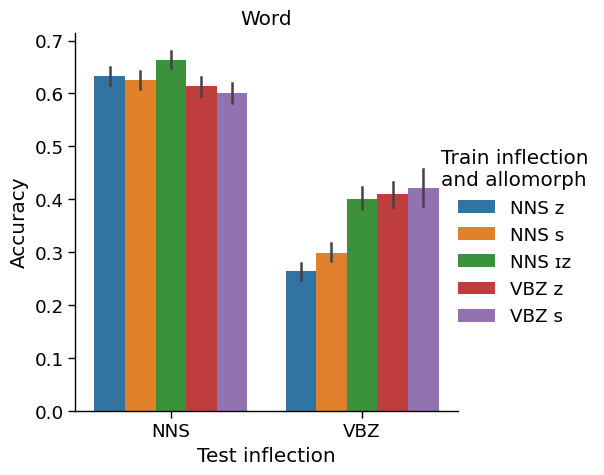

In [48]:
nnvb_focus_bar = nnvb_focus.assign(source_label=lambda xs: xs.inflection_from + " " + xs.allomorph_from)
nnvb_focus_bar = nnvb_focus_bar[(nnvb_focus_bar.source_label != "VBZ ɪz")]
order = nnvb_focus_bar.groupby("source_label").correct.mean().sort_values().index
g = sns.catplot(data=nnvb_focus_bar, x="inflection_to", hue="source_label", y="correct", col="model_label", kind="bar")
g._legend.set_title("Train inflection\nand allomorph")

for ax in g.axes.flat:
    ax.set_title(ax.get_title().split("=")[1].strip())
    ax.set_xlabel("Test inflection")
    ax.set_ylabel("Accuracy")

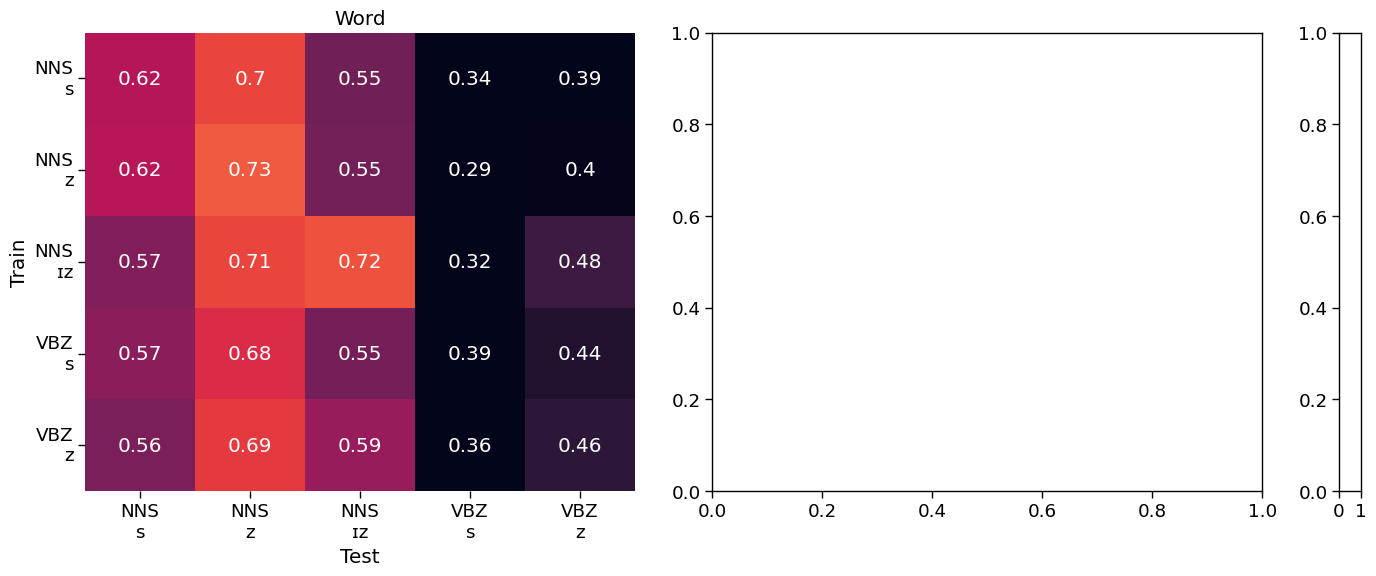

In [49]:
# f, ax = plt.subplots(1, 2, figsize=(7 * 2, 6))

f, axs = plt.subplots(1, 3, figsize=(7 * 2, 6), gridspec_kw={'width_ratios': [1, 1, 0.04]})
for i, (ax, (model_label, rows)) in enumerate(zip(axs, nnvb_results_summary.groupby("model_label"))):
    cbar_ax = None
    if i == 1:
        cbar_ax = axs.flat[-1]

    ax.set_title(model_label)
    sns.heatmap(rows.set_index(["source_label", "target_label"]).sort_index()["mean"].unstack("target_label"),
                vmin=main_plot_vmin, vmax=main_plot_vmax, annot=True, ax=ax,
                cbar=i == 1, cbar_ax=cbar_ax)

    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.set_ylabel("Train")
    ax.set_xlabel("Test")

f.tight_layout()
f.savefig(f"{output_dir}/nnvb_allomorphs.pdf")

In [68]:
nnvb_results_summary2 = nnvb_focus.groupby(["model_label", "inflection_from", "inflection_to"]) \
    [["correct", "gt_label_rank", "gt_distance"]].mean().reset_index() \
    .astype({"correct": float})

nnvb_results_summary2["transfer_label"] = nnvb_results_summary2.inflection_from + " -> " + nnvb_results_summary2.inflection_to
nnvb_results_summary2

,model_label,inflection_from,inflection_to,correct,gt_label_rank,gt_distance,transfer_label
0,Word,NNS,NNS,0.640778,3.056778,1.044443,NNS -> NNS
1,Word,NNS,VBZ,0.313936,18.760592,0.987619,NNS -> VBZ
2,Word,VBZ,NNS,0.586524,4.472818,1.043608,VBZ -> NNS
3,Word,VBZ,VBZ,0.408958,12.498179,0.985470,VBZ -> VBZ


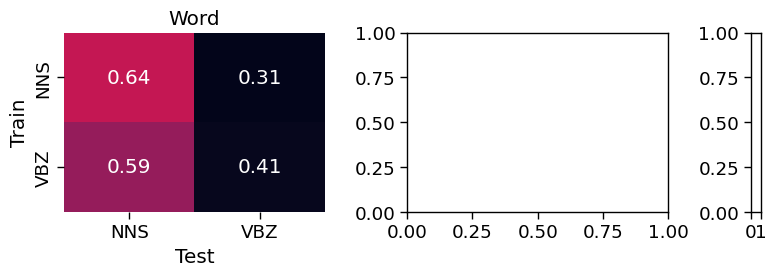

In [69]:
f, axs = plt.subplots(1, 3, figsize=(4 * 2, 3), gridspec_kw={'width_ratios': [1, 1, 0.04]})

for i, (ax, (model_label, rows)) in enumerate(zip(axs, nnvb_results_summary2.groupby("model_label"))):
    cbar_ax = None
    if i == 1:
        cbar_ax = axs.flat[-1]
    
    ax.set_title(model_label)
    sns.heatmap(rows.set_index(["inflection_from", "inflection_to"]).correct.unstack(),
                annot=True, vmin=main_plot_vmin, vmax=main_plot_vmax, ax=ax,
                cbar=i == 1, cbar_ax=cbar_ax)
    ax.set_xlabel("Test")
    ax.set_ylabel("Train")

f = plt.gcf()
f.tight_layout()
f.savefig(f"{output_dir}/nnvb_results.pdf")

/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


Text(55.33481032986113, 0.5, 'Accuracy')

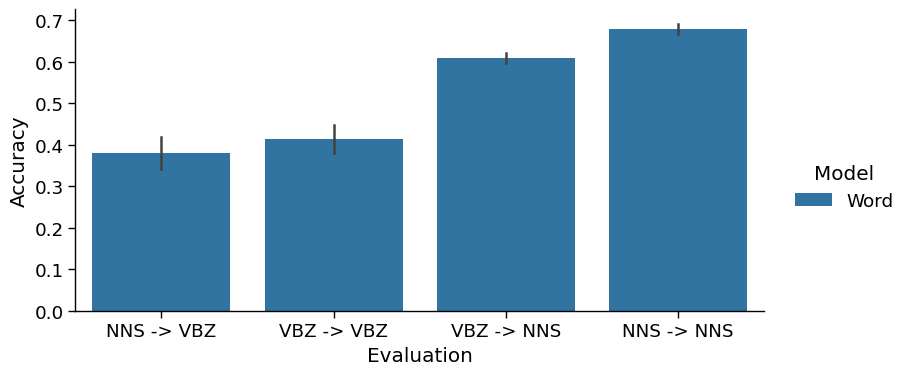

In [70]:
nnvb_plot = nnvb_focus.groupby(["model_label", "inflection_from", "inflection_to", "base_to"]).correct.mean().reset_index()
nnvb_plot["transfer_label"] = nnvb_plot.inflection_from + " -> " + nnvb_plot.inflection_to
order = nnvb_plot.groupby("transfer_label").correct.mean().sort_values().index
g = sns.catplot(data=nnvb_plot, x="transfer_label", y="correct", kind="bar", hue="model_label", order=order, errorbar="se", height=4, aspect=2)
g._legend.set_title("Model")
ax = g.axes.flat[0]

ax.set_xlabel("Evaluation")
ax.set_ylabel("Accuracy")

/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


Text(70.44940711805556, 0.5, 'Accuracy')

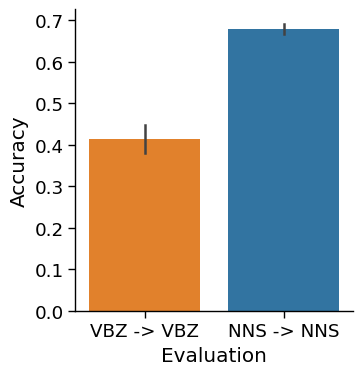

In [71]:
nnvb_phase1 = nnvb_plot[nnvb_plot.inflection_from == nnvb_plot.inflection_to]
order = nnvb_phase1.groupby("transfer_label").correct.mean().sort_values().index
g = sns.catplot(data=nnvb_phase1, x="transfer_label", y="correct", kind="bar", hue="inflection_to", order=order, errorbar="se", height=4, aspect=1)
# remove legend
g._legend.remove()
ax = g.axes.flat[0]

ax.set_xlabel("Evaluation")
ax.set_ylabel("Accuracy")

### Correct for verb paradigm size

In [72]:
study_df = nnvb_focus[(nnvb_focus.inflection_to == "VBZ")].copy()

In [73]:
study_df["predicted_stem"] = study_df.predicted_label.str.replace(r"s$|ed$|ings?$", "", regex=True)
study_df["base_to_stem"] = study_df.base_to.str.replace(r"e$", "", regex=True).replace(r"y$", "i", regex=True)
study_df["predicted_within_inflection"] = \
    (study_df.predicted_stem == study_df.base_to) | (study_df.predicted_stem == study_df.base_to_stem)
vb_irregulars = [("do", "did"), ("do", "does"), ("begin", "began"), ("learn", "learnt"), ("send", "sent"), ("shine", "shone"), ("seem", "seem'd"), ("read", "red"),
                 ("possess", "possesses"), ("bring", "brings"), ("carry", "carries"), ("occur", "occurred"), ("think", "thinkest"), ("grow", "grew"),
                 ("put", "putting"), ("begin", "beginning"), ("give", "givest"),
                 # homophones
                 ("allow", "aloud"), ("write", "rights"), ("write", "wright's"), ("depend", "dependent")]
for base, predicted in vb_irregulars:
    study_df.loc[study_df.base_to == base, "predicted_within_inflection"] |= study_df.loc[study_df.base_to == base].predicted_label == predicted

In [74]:
merge_keys = ["experiment", "equivalence", "model_label", "model_name", "base_model_name", "group", "inflection_from", "inflection_to", "base_from", "inflected_from", "base_to", "inflected_to"]
nnvb_focus = pd.merge(nnvb_focus.reset_index(), study_df.reset_index()[merge_keys + ["predicted_within_inflection"]],
         on=merge_keys, how="left")

In [75]:
nnvb_focus["correct_or_predicted_within_inflection"] = nnvb_focus.correct | nnvb_focus.predicted_within_inflection

In [76]:
nnvb_results_summary2 = nnvb_focus.groupby(["model_label", "inflection_from", "inflection_to"]) \
    [["correct_or_predicted_within_inflection", "correct", "gt_label_rank", "gt_distance"]].mean().reset_index()

nnvb_results_summary2["transfer_label"] = nnvb_results_summary2.inflection_from + " -> " + nnvb_results_summary2.inflection_to
nnvb_results_summary2

,model_label,inflection_from,inflection_to,correct_or_predicted_within_inflection,correct,gt_label_rank,gt_distance,transfer_label
0,Word,NNS,NNS,0.640778,0.640778,3.056778,1.044443,NNS -> NNS
1,Word,NNS,VBZ,0.631189,0.313936,18.760592,0.987619,NNS -> VBZ
2,Word,VBZ,NNS,0.586524,0.586524,4.472818,1.043608,VBZ -> NNS
3,Word,VBZ,VBZ,0.743991,0.408958,12.498179,0.985470,VBZ -> VBZ


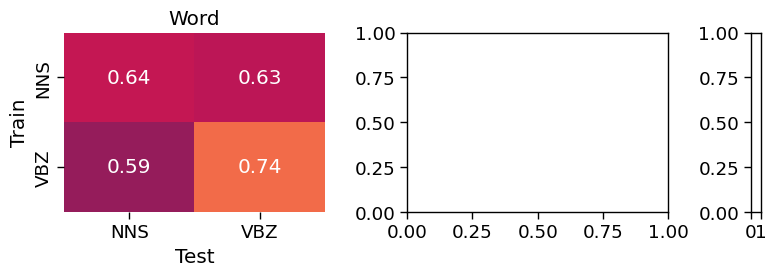

In [77]:
f, axs = plt.subplots(1, 3, figsize=(4 * 2, 3), gridspec_kw={'width_ratios': [1, 1, 0.04]})

for i, (ax, (model_label, rows)) in enumerate(zip(axs, nnvb_results_summary2.groupby("model_label"))):
    cbar_ax = None
    if i == 1:
        cbar_ax = axs.flat[-1]
    
    ax.set_title(model_label)
    sns.heatmap(rows.set_index(["inflection_from", "inflection_to"]).correct_or_predicted_within_inflection.unstack(),
                vmin=main_plot_vmin, vmax=main_plot_vmax,
                annot=True, ax=ax, cbar=i == 1, cbar_ax=cbar_ax)
    ax.set_xlabel("Test")
    ax.set_ylabel("Train")

f = plt.gcf()
f.tight_layout()
f.savefig(f"{output_dir}/nnvb_results-correct_inflection.pdf")

/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


Text(56.50454991319448, 0.5, 'Accuracy')

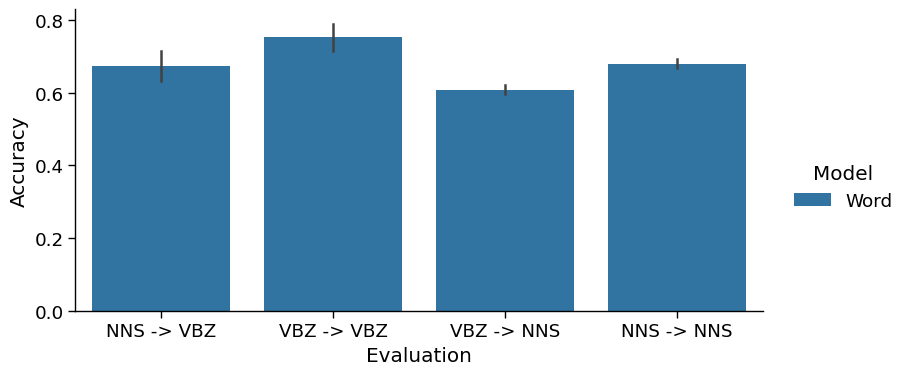

In [78]:
nnvb_plot = nnvb_focus.groupby(["model_label", "inflection_from", "inflection_to", "base_to"]).correct_or_predicted_within_inflection.mean().reset_index()
nnvb_plot["transfer_label"] = nnvb_plot.inflection_from + " -> " + nnvb_plot.inflection_to
order = ["NNS -> VBZ", "VBZ -> VBZ", "VBZ -> NNS", "NNS -> NNS"]
g = sns.catplot(data=nnvb_plot, x="transfer_label", y="correct_or_predicted_within_inflection", kind="bar", hue="model_label", order=order, errorbar="se", height=4, aspect=2)
g._legend.set_title("Model")
ax = g.axes.flat[0]

ax.set_xlabel("Evaluation")
ax.set_ylabel("Accuracy")

### Frequency analysis

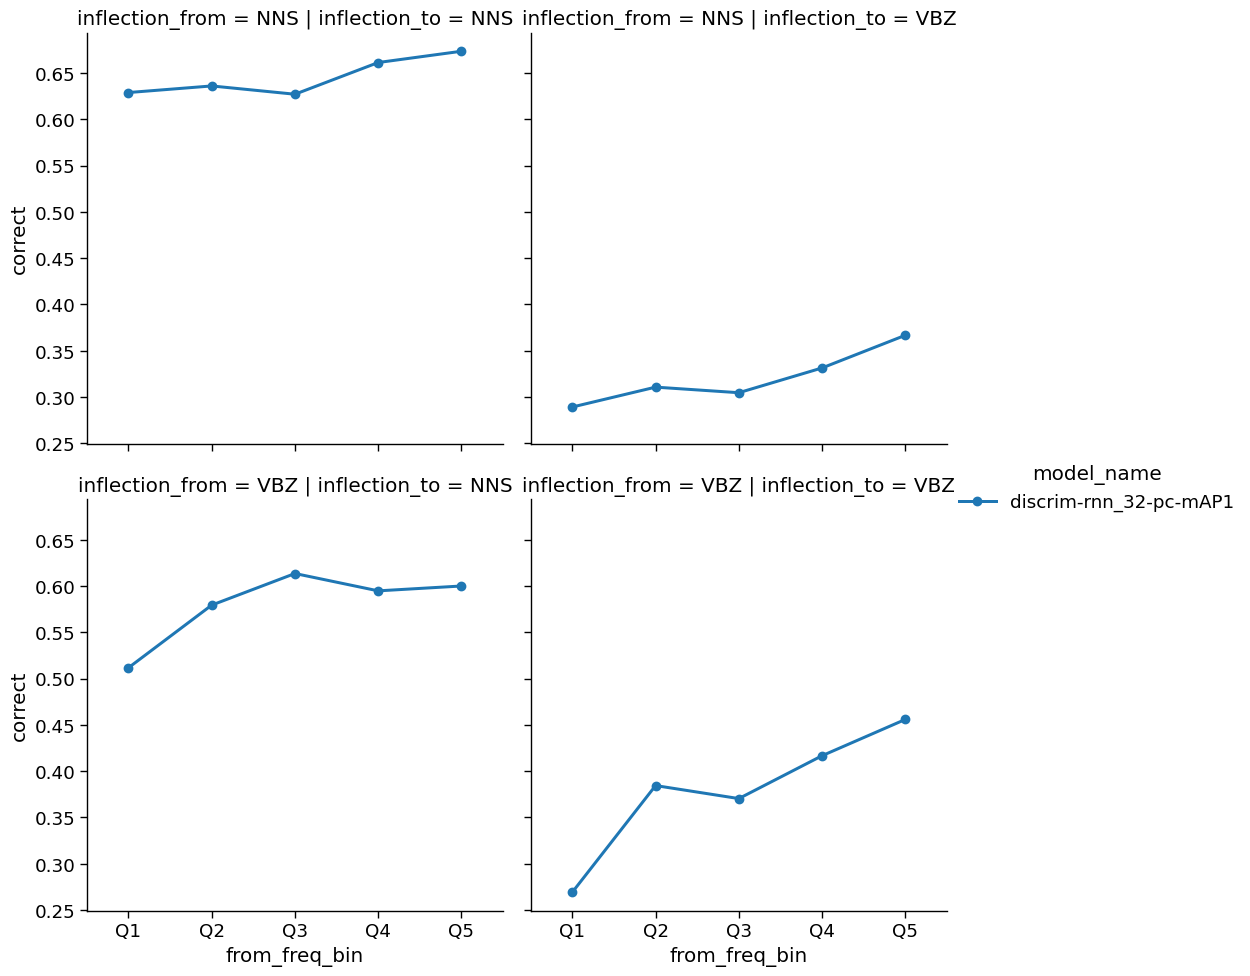

In [81]:
sns.catplot(data=all_nnvb_results.query("base_model_name == 'w2v2_pc_8'").reset_index(),
            x="from_freq_bin", y="correct", hue="model_name",
            row="inflection_from", col="inflection_to", units="base_from",
            kind="point", errorbar=None)

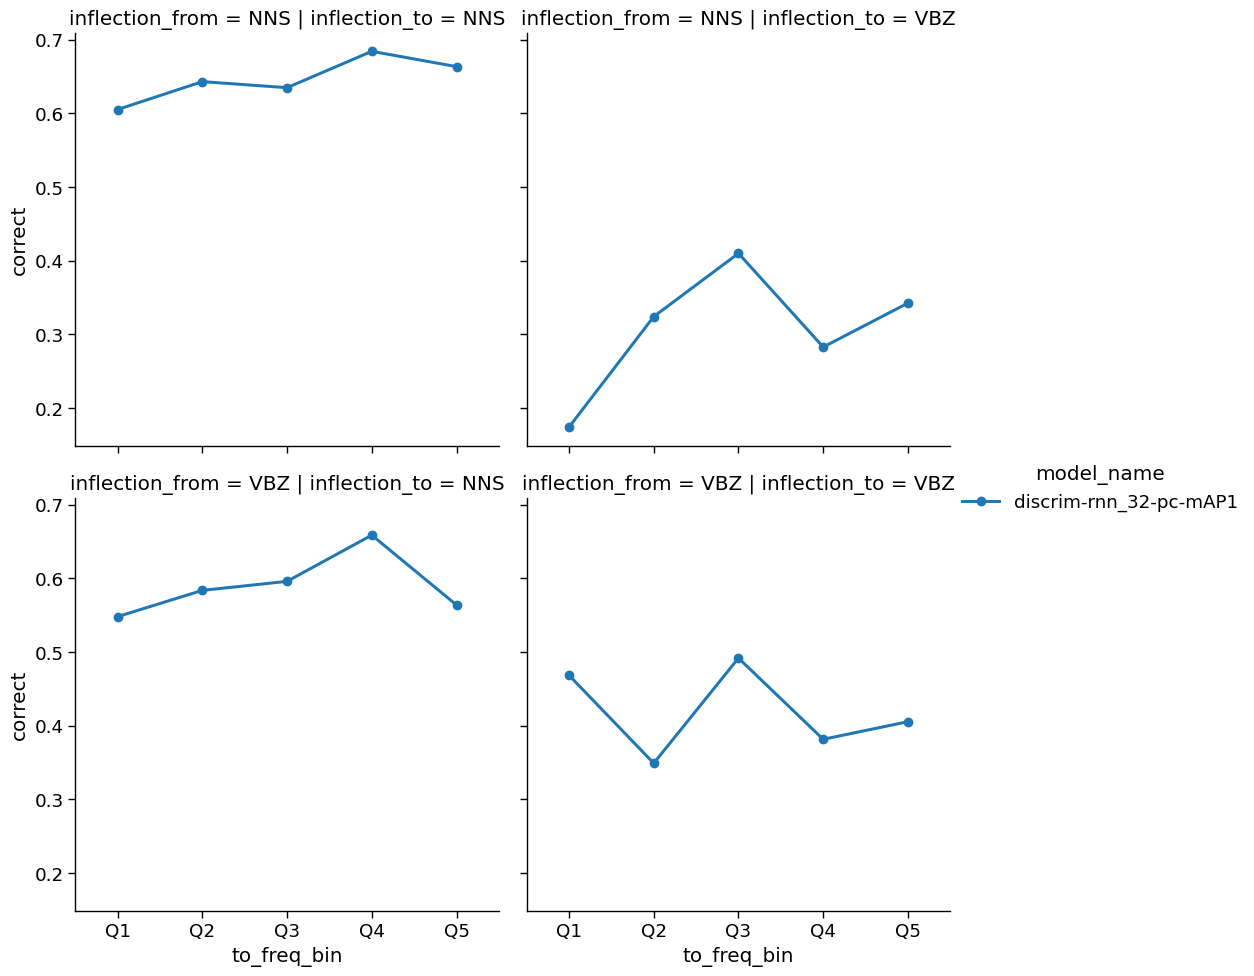

In [83]:
sns.catplot(data=all_nnvb_results.query("base_model_name == 'w2v2_pc_8'").reset_index(),
            x="to_freq_bin", y="correct", hue="model_name",
            row="inflection_from", col="inflection_to", units="base_to",
            kind="point", errorbar=None)

## Controlled VBD analysis

In [84]:
all_vbd_results = all_results.query("experiment == 'regular' and inflection_from == 'VBD'")
all_vbd_results = pd.merge(all_vbd_results, most_common_allomorphs.rename(columns={"base": "base_from", "inflection": "inflection_from", "most_common_allomorph": "allomorph_from"}),
               on=["base_from", "inflection_from"], how="left")
all_vbd_results = pd.merge(all_vbd_results, most_common_allomorphs.rename(columns={"base": "base_to", "inflection": "inflection_to", "most_common_allomorph": "allomorph_to"}),
               on=["base_to", "inflection_to"], how="left")
all_vbd_results[["allomorph_from", "allomorph_to"]].value_counts()

allomorph_from  allomorph_to
D               D               238
T               D               103
D               IH D            102
IH D            D               101
D               T               100
                               ... 
EH P T          D                 1
                EH L D            1
                EH L T            1
                EY M              1
                AE T              1
Name: count, Length: 748, dtype: int64

In [85]:
keep_vbd_allomorphs = all_vbd_results.allomorph_from.value_counts().head(3).index
all_vbd_results = all_vbd_results[all_vbd_results.allomorph_from.isin(keep_vbd_allomorphs)
                                  & all_vbd_results.allomorph_to.isin(keep_vbd_allomorphs)]

In [86]:
# Add frequency information

all_vbd_results["inflected_from"] = all_vbd_results.from_equiv_label.apply(lambda x: eval(x)[1])
all_vbd_results["inflected_to"] = all_vbd_results.to_equiv_label.apply(lambda x: eval(x)[1])

all_vbd_results = pd.merge(all_vbd_results, word_freq_df["LogFreq"].rename("from_base_freq"),
                           left_on="base_from", right_index=True)
all_vbd_results = pd.merge(all_vbd_results, word_freq_df["LogFreq"].rename("to_base_freq"),
                           left_on="base_to", right_index=True)
all_vbd_results = pd.merge(all_vbd_results, word_freq_df["LogFreq"].rename("from_inflected_freq"),
                            left_on="inflected_from", right_index=True)
all_vbd_results = pd.merge(all_vbd_results, word_freq_df["LogFreq"].rename("to_inflected_freq"),
                            left_on="inflected_to", right_index=True)

all_vbd_results["from_freq"] = all_vbd_results[["from_base_freq", "from_inflected_freq"]].mean(axis=1)
all_vbd_results["to_freq"] = all_vbd_results[["to_base_freq", "to_inflected_freq"]].mean(axis=1)

_, vbd_frequency_bins = pd.qcut(pd.concat([all_vbd_results.to_freq, all_vbd_results.from_freq]), q=3, retbins=True)
all_vbd_results["from_freq_bin"] = pd.cut(all_vbd_results.from_freq, bins=vbd_frequency_bins, labels=[f"Q{i}" for i in range(1, 4)])
all_vbd_results["to_freq_bin"] = pd.cut(all_vbd_results.to_freq, bins=vbd_frequency_bins, labels=[f"Q{i}" for i in range(1, 4)])

In [87]:
def summarize_vbd_run(rows):
    rows["source_label"] = rows.inflection_from + " " + rows.allomorph_from
    rows["target_label"] = rows.inflection_to + " " + rows.allomorph_to

    rows["transfer_label"] = rows.inflection_from + " -> " + rows.inflection_to
    rows["phon_label"] = rows.allomorph_from + " -> " + rows.allomorph_to

    return rows

summary_groupers = ["inflection_from", "inflection_to", "allomorph_from", "allomorph_to"]
vbd_results_summary = all_vbd_results.groupby(run_groupers + summary_groupers) \
    .correct.agg(["count", "mean"]) \
    .reset_index(summary_groupers) \
    .groupby(run_groupers, group_keys=False) \
    .apply(summarize_vbd_run) \
    .reset_index()

vbd_results_summary

,base_model_name,model_name,equivalence,inflection_from,inflection_to,allomorph_from,allomorph_to,count,mean,source_label,target_label,transfer_label,phon_label
0,w2v2_pc_8,discrim-rnn_32-pc-mAP1,word_broad_10frames_fixedlen25,VBD,VBD,D,D,238,0.613445,VBD D,VBD D,VBD -> VBD,D -> D
1,w2v2_pc_8,discrim-rnn_32-pc-mAP1,word_broad_10frames_fixedlen25,VBD,VBD,D,IH D,102,0.549020,VBD D,VBD IH D,VBD -> VBD,D -> IH D
2,w2v2_pc_8,discrim-rnn_32-pc-mAP1,word_broad_10frames_fixedlen25,VBD,VBD,D,T,100,0.610000,VBD D,VBD T,VBD -> VBD,D -> T
3,w2v2_pc_8,discrim-rnn_32-pc-mAP1,word_broad_10frames_fixedlen25,VBD,VBD,IH D,D,101,0.564356,VBD IH D,VBD D,VBD -> VBD,IH D -> D
4,w2v2_pc_8,discrim-rnn_32-pc-mAP1,word_broad_10frames_fixedlen25,VBD,VBD,IH D,IH D,38,0.526316,VBD IH D,VBD IH D,VBD -> VBD,IH D -> IH D
5,w2v2_pc_8,discrim-rnn_32-pc-mAP1,word_broad_10frames_fixedlen25,VBD,VBD,IH D,T,37,0.567568,VBD IH D,VBD T,VBD -> VBD,IH D -> T
6,w2v2_pc_8,discrim-rnn_32-pc-mAP1,word_broad_10frames_fixedlen25,VBD,VBD,T,D,103,0.563107,VBD T,VBD D,VBD -> VBD,T -> D
7,w2v2_pc_8,discrim-rnn_32-pc-mAP1,word_broad_10frames_fixedlen25,VBD,VBD,T,IH D,34,0.382353,VBD T,VBD IH D,VBD -> VBD,T -> IH D
8,w2v2_pc_8,discrim-rnn_32-pc-mAP1,word_broad_10frames_fixedlen25,VBD,VBD,T,T,28,0.571429,VBD T,VBD T,VBD -> VBD,T -> T


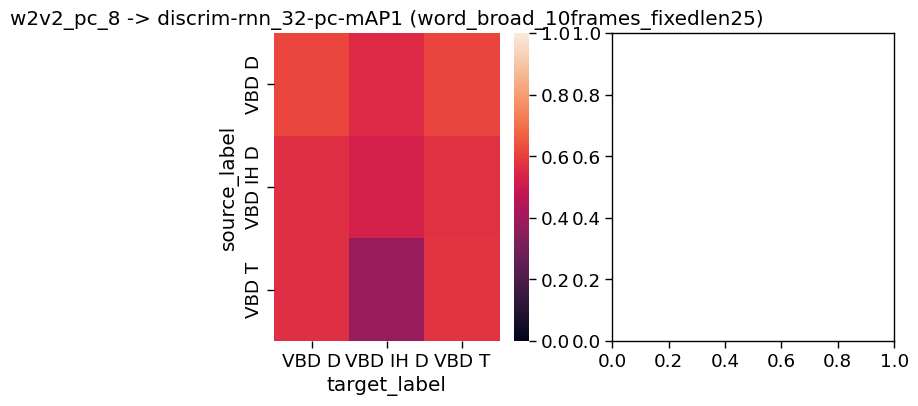

In [88]:
plot_results = []
for base_model_name, model_name, equivalence in plot_runs:
    results_i = vbd_results_summary.query("base_model_name == @base_model_name and model_name == @model_name and equivalence == @equivalence")
    if len(results_i) > 0:
        plot_results.append(results_i)
num_plot_runs = len(plot_results)

ncols = 2
nrows = int(np.ceil(num_plot_runs / ncols))
f, axs = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4))

for ax, results_i in zip(axs.flat, plot_results):
    sns.heatmap(results_i.set_index(["source_label", "target_label"])["mean"].unstack(),
                vmin=0, vmax=1, ax=ax)
    key_row = results_i.iloc[0]
    ax.set_title(f"{key_row.base_model_name} -> {key_row.model_name} ({key_row.equivalence})")

In [89]:
vbd_focus = all_vbd_results.query("base_model_name == @focus_base_model and model_name == @focus_model and equivalence == @focus_equivalence")
vbd_foil = all_vbd_results.query("base_model_name == @foil_base_model and model_name == @foil_model and equivalence == @foil_equivalence")
vbd_focus["model_label"] = "Word"
vbd_foil["model_label"] = "Wav2Vec"
vbd_focus = pd.concat([vbd_focus, vbd_foil])

vbd_results_summary2 = vbd_focus.groupby(["model_label", "inflection_from", "inflection_to"]) \
    [["correct", "gt_label_rank", "gt_distance"]].mean().reset_index()

vbd_results_summary2["transfer_label"] = vbd_results_summary2.inflection_from + " -> " + vbd_results_summary2.inflection_to
vbd_results_summary2

,model_label,inflection_from,inflection_to,correct,gt_label_rank,gt_distance,transfer_label
0,Word,VBD,VBD,0.573624,28.528809,0.941748,VBD -> VBD


### Focused plots

In [90]:
focus_base_model, focus_model, focus_equivalence = main_plot_run
foil_base_model, foil_model, foil_equivalence = "w2v2_8", "id", "id"

vbd_focus = all_vbd_results.query("base_model_name == @focus_base_model and model_name == @focus_model and equivalence == @focus_equivalence")
vbd_foil = all_vbd_results.query("base_model_name == @foil_base_model and model_name == @foil_model and equivalence == @foil_equivalence")
vbd_focus["model_label"] = "Word"
vbd_foil["model_label"] = "Wav2Vec"

vbd_focus = pd.concat([vbd_focus, vbd_foil])

allomorph_labels = {"D": "d", "T": "t", "IH D": "ɪd"}
vbd_focus["allomorph_from"] = vbd_focus.allomorph_from.map(allomorph_labels)
vbd_focus["allomorph_to"] = vbd_focus.allomorph_to.map(allomorph_labels)
vbd_focus

,index,equivalence,model_name,base_model_name,experiment,Unnamed: 1,group,from_equiv_label,to_equiv_label,base_from,...,inflected_to,from_base_freq,to_base_freq,from_inflected_freq,to_inflected_freq,from_freq,to_freq,from_freq_bin,to_freq_bin,model_label
181,8047,word_broad_10frames_fixedlen25,discrim-rnn_32-pc-mAP1,w2v2_pc_8,regular,2047.0,"(VBD, False)","('hide', 'hid')","('make', 'made')",hide,...,made,3.009055,4.641601,2.218776,4.436176,2.613916,4.538888,Q2,Q3,Word
304,8170,word_broad_10frames_fixedlen25,discrim-rnn_32-pc-mAP1,w2v2_pc_8,regular,2170.0,"(VBD, False)","('lead', 'led')","('dwell', 'dwelt')",lead,...,dwelt,3.769585,2.232318,3.578256,1.282249,3.673921,1.757284,Q3,Q1,Word
412,8278,word_broad_10frames_fixedlen25,discrim-rnn_32-pc-mAP1,w2v2_pc_8,regular,2278.0,"(VBD, False)","('have', 'had')","('build', 'built')",have,...,built,5.247426,3.513097,4.879203,3.444056,5.063315,3.478577,Q3,Q3,Word
512,8378,word_broad_10frames_fixedlen25,discrim-rnn_32-pc-mAP1,w2v2_pc_8,regular,2378.0,"(VBD, False)","('lend', 'lent')","('make', 'made')",lend,...,made,2.397738,4.641601,2.400606,4.436176,2.399172,4.538888,Q2,Q3,Word
570,8436,word_broad_10frames_fixedlen25,discrim-rnn_32-pc-mAP1,w2v2_pc_8,regular,2436.0,"(VBD, False)","('bend', 'bent')","('send', 'sent')",bend,...,sent,2.648001,3.738118,2.496198,3.667339,2.572099,3.702729,Q2,Q3,Word
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,9861,word_broad_10frames_fixedlen25,discrim-rnn_32-pc-mAP1,w2v2_pc_8,regular,3861.0,"(VBD, True)","('hope', 'hoped')","('assure', 'assured')",hope,...,assured,4.299479,2.393372,2.902086,2.607424,3.600782,2.500398,Q3,Q2,Word
1996,9862,word_broad_10frames_fixedlen25,discrim-rnn_32-pc-mAP1,w2v2_pc_8,regular,3862.0,"(VBD, True)","('establish', 'established')","('smoke', 'smoked')",establish,...,smoked,2.723676,3.192087,3.005068,2.693423,2.864372,2.942755,Q2,Q2,Word
1997,9863,word_broad_10frames_fixedlen25,discrim-rnn_32-pc-mAP1,w2v2_pc_8,regular,3863.0,"(VBD, True)","('neglect', 'neglected')","('exceed', 'exceeded')",neglect,...,exceeded,2.391758,2.289121,2.375635,2.230652,2.383697,2.259887,Q2,Q1,Word
1998,9864,word_broad_10frames_fixedlen25,discrim-rnn_32-pc-mAP1,w2v2_pc_8,regular,3864.0,"(VBD, True)","('include', 'included')","('experience', 'experienced')",include,...,experienced,3.649665,3.842482,3.465604,3.095561,3.557635,3.469021,Q3,Q3,Word


In [91]:
vbd_results_summary = vbd_focus.groupby(["model_label", "inflection_from", "inflection_to",
                                             "allomorph_from", "allomorph_to"]) \
    .correct.agg(["count", "mean"]) \
    .query("count >= 0") \
    .reset_index()

vbd_results_summary["source_label"] = vbd_results_summary.inflection_from + "\n" + vbd_results_summary.allomorph_from
vbd_results_summary["target_label"] = vbd_results_summary.inflection_to + "\n" + vbd_results_summary.allomorph_to

vbd_results_summary["transfer_label"] = vbd_results_summary.inflection_from + " -> " + vbd_results_summary.inflection_to
vbd_results_summary["phon_label"] = vbd_results_summary.allomorph_from + " " + vbd_results_summary.allomorph_to

# only retain cases where we have data in both transfer directions from source <-> target within inflection
vbd_results_summary["complement_exists"] = vbd_results_summary.apply(lambda row: len(vbd_results_summary.query("source_label == @row.target_label and target_label == @row.source_label")), axis=1)
vbd_results_summary = vbd_results_summary.query("complement_exists > 0").drop(columns=["complement_exists"])

vbd_results_summary

,model_label,inflection_from,inflection_to,allomorph_from,allomorph_to,count,mean,source_label,target_label,transfer_label,phon_label
0,Word,VBD,VBD,d,d,238,0.613445,VBD\nd,VBD\nd,VBD -> VBD,d d
1,Word,VBD,VBD,d,t,100,0.610000,VBD\nd,VBD\nt,VBD -> VBD,d t
2,Word,VBD,VBD,d,ɪd,102,0.549020,VBD\nd,VBD\nɪd,VBD -> VBD,d ɪd
3,Word,VBD,VBD,t,d,103,0.563107,VBD\nt,VBD\nd,VBD -> VBD,t d
4,Word,VBD,VBD,t,t,28,0.571429,VBD\nt,VBD\nt,VBD -> VBD,t t
5,Word,VBD,VBD,t,ɪd,34,0.382353,VBD\nt,VBD\nɪd,VBD -> VBD,t ɪd
6,Word,VBD,VBD,ɪd,d,101,0.564356,VBD\nɪd,VBD\nd,VBD -> VBD,ɪd d
7,Word,VBD,VBD,ɪd,t,37,0.567568,VBD\nɪd,VBD\nt,VBD -> VBD,ɪd t
8,Word,VBD,VBD,ɪd,ɪd,38,0.526316,VBD\nɪd,VBD\nɪd,VBD -> VBD,ɪd ɪd


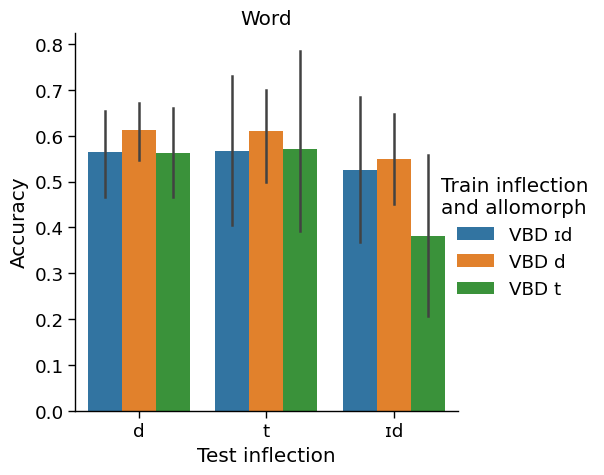

In [92]:
vbd_focus_bar = vbd_focus.assign(source_label=lambda xs: xs.inflection_from + " " + xs.allomorph_from)
order = vbd_focus_bar.groupby("source_label").correct.mean().sort_values().index
g = sns.catplot(data=vbd_focus_bar, x="allomorph_to", hue="source_label", y="correct", col="model_label", kind="bar")
g._legend.set_title("Train inflection\nand allomorph")

for ax in g.axes.flat:
    ax.set_title(ax.get_title().split("=")[1].strip())
    ax.set_xlabel("Test inflection")
    ax.set_ylabel("Accuracy")

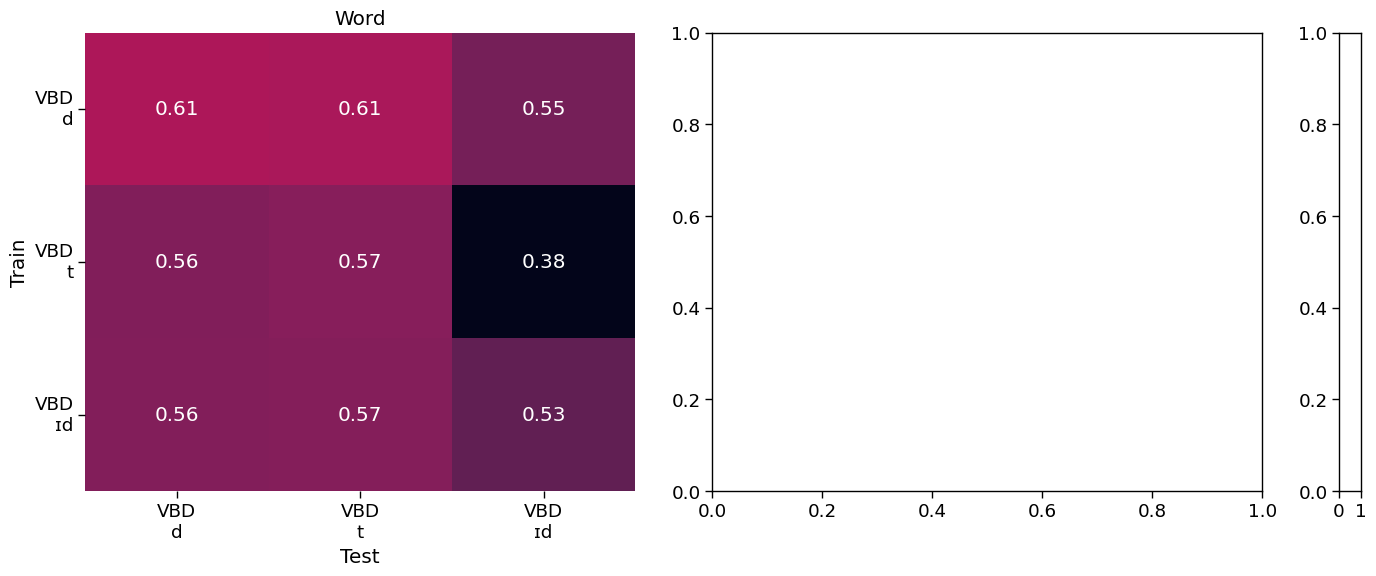

In [93]:
# f, ax = plt.subplots(1, 2, figsize=(7 * 2, 6))

f, axs = plt.subplots(1, 3, figsize=(7 * 2, 6), gridspec_kw={'width_ratios': [1, 1, 0.04]})
for i, (ax, (model_label, rows)) in enumerate(zip(axs, vbd_results_summary.groupby("model_label"))):
    cbar_ax = None
    if i == 1:
        cbar_ax = axs.flat[-1]

    ax.set_title(model_label)
    sns.heatmap(rows.set_index(["source_label", "target_label"]).sort_index()["mean"].unstack("target_label"),
                vmin=main_plot_vmin, vmax=main_plot_vmax, annot=True, ax=ax,
                cbar=i == 1, cbar_ax=cbar_ax)

    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.set_ylabel("Train")
    ax.set_xlabel("Test")

f.tight_layout()
f.savefig(f"{output_dir}/vbd_allomorphs.pdf")

## False friend analysis

In [94]:
all_ff_results = []

for run, run_results in all_results.groupby(run_groupers):
    run_results = run_results.set_index("experiment")
    false_friend_expts = run_results.index.unique()
    false_friend_expts = false_friend_expts[false_friend_expts.str.contains("FF")]

    for expt_name in false_friend_expts:
        expt_df = run_results.loc[expt_name].copy()
        num_seen_words = min(len(expt_df.base_from.unique()), len(expt_df.base_to.unique()))

        if num_seen_words < 10:
            print(f"Skipping {expt} due to only {num_seen_words} seen words")
            continue

        if expt_name.count("-FF-") == 2:
            allomorph_from, allomorph_to = re.findall(r"-FF-([\w\s]+)-to-.+FF-([\w\s]+)", expt_name)[0]
            ff_from, ff_to = True, True
        else:
            try:
                allomorph_from, allomorph_to = re.findall(r"_([\w\s]+)-to-.+FF-([\w\s]+)", expt_name)[0]
                # is the false friend on the "from" side?
                ff_from, ff_to = False, True
            except:
                allomorph_from, allomorph_to = re.findall(r".+FF-([\w\s]+)-to-.+_([\w\s]+)", expt_name)[0]
                ff_from, ff_to = True, False

        expt_df["allomorph_from"] = allomorph_from
        expt_df["allomorph_to"] = allomorph_to

        if ff_from:
            expt_df["inflection_from"] = expt_df.inflection_from.str.replace("-FF-.+", "-FF", regex=True)
        if ff_to:
            expt_df["inflection_to"] = expt_df.inflection_to.str.replace("-FF-.+", "-FF", regex=True)

        expt_df["ff_from"] = ff_from
        expt_df["ff_to"] = ff_to

        all_ff_results.append(expt_df)

    # add within-false-friend tests
    expt_df = run_results.loc["false_friends"].copy()
    expt_df["allomorph_from"] = expt_df.inflection_from.str.extract(r"FF-(.+)$")
    expt_df["allomorph_to"] = expt_df.inflection_to.str.extract(r"FF-(.+)$")
    expt_df["inflection_from"] = expt_df.inflection_from.str.replace("-FF-.+", "-FF", regex=True)
    expt_df["inflection_to"] = expt_df.inflection_to.str.replace("-FF-.+", "-FF", regex=True)
    expt_df["ff_from"] = True
    expt_df["ff_to"] = True

    all_ff_results.append(expt_df)

    # expt_df = expt_df[expt_df.inflection_from.isin(all_ff_results.inflection_from.unique())]

all_ff_results = pd.concat(all_ff_results).reset_index()

ff_exclude = "a b c wreck d e eh wandering lo chiu ha hahn meek jew shew"
ff_exclude_inflected = "bunce los oft mast hauled "

# exclude FF bases
all_ff_results = all_ff_results[~(all_ff_results.inflection_from.str.endswith("-FF") & all_ff_results.base_from.isin(ff_exclude.split()))]
all_ff_results = all_ff_results[~(all_ff_results.inflection_to.str.endswith("-FF") & all_ff_results.base_to.isin(ff_exclude.split()))]

all_ff_results["inflected_from"] = all_ff_results.from_equiv_label.apply(lambda x: eval(x)[1])
all_ff_results["inflected_to"] = all_ff_results.to_equiv_label.apply(lambda x: eval(x)[1])

# exclude FF inflected
all_ff_results = all_ff_results[~(all_ff_results.inflection_from.str.endswith("-FF") & all_ff_results.inflected_from.isin(ff_exclude_inflected.split()))]
all_ff_results = all_ff_results[~(all_ff_results.inflection_to.str.endswith("-FF") & all_ff_results.inflected_to.isin(ff_exclude_inflected.split()))]

# add frequency information
all_ff_results = pd.merge(all_ff_results, word_freq_df["LogFreq"].rename("from_base_freq"), left_on="base_from", right_index=True)
all_ff_results = pd.merge(all_ff_results, word_freq_df["LogFreq"].rename("to_base_freq"), left_on="base_to", right_index=True)
all_ff_results = pd.merge(all_ff_results, word_freq_df["LogFreq"].rename("from_inflected_freq"), left_on="inflected_from", right_index=True)
all_ff_results = pd.merge(all_ff_results, word_freq_df["LogFreq"].rename("to_inflected_freq"), left_on="inflected_to", right_index=True)
all_ff_results["from_freq"] = all_ff_results[["from_base_freq", "from_inflected_freq"]].mean(axis=1)
all_ff_results["to_freq"] = all_ff_results[["to_base_freq", "to_inflected_freq"]].mean(axis=1)

all_ff_results["transfer_label"] = all_ff_results.inflection_from + " -> " + all_ff_results.inflection_to

Skipping unambiguous-VBZ_IH Z_to_VBZ_IH Z due to only 1 seen words
Skipping unambiguous-VBZ_IH Z_to_VBZ_IH Z due to only 1 seen words
Skipping unambiguous-VBZ_IH Z_to_VBZ_IH Z due to only 1 seen words
Skipping unambiguous-VBZ_IH Z_to_VBZ_IH Z due to only 1 seen words
Skipping unambiguous-VBZ_IH Z_to_VBZ_IH Z due to only 1 seen words
Skipping unambiguous-VBZ_IH Z_to_VBZ_IH Z due to only 1 seen words
Skipping unambiguous-VBZ_IH Z_to_VBZ_IH Z due to only 1 seen words
Skipping unambiguous-VBZ_IH Z_to_VBZ_IH Z due to only 1 seen words
Skipping unambiguous-VBZ_IH Z_to_VBZ_IH Z due to only 1 seen words
Skipping unambiguous-VBZ_IH Z_to_VBZ_IH Z due to only 1 seen words
Skipping unambiguous-VBZ_IH Z_to_VBZ_IH Z due to only 1 seen words
Skipping unambiguous-VBZ_IH Z_to_VBZ_IH Z due to only 1 seen words
Skipping unambiguous-VBZ_IH Z_to_VBZ_IH Z due to only 4 seen words
Skipping unambiguous-VBZ_IH Z_to_VBZ_IH Z due to only 4 seen words
Skipping unambiguous-VBZ_IH Z_to_VBZ_IH Z due to only 4 seen w

In [95]:
# Post-hoc fix some bugs
all_ff_results.loc[(all_ff_results.base_to == "tho") & (all_ff_results.predicted_label == "though") & (all_ff_results.gt_label_rank == 1), "correct"] = True
all_ff_results.loc[(all_ff_results.base_to == "philip") & (all_ff_results.predicted_label == "philip's"), "correct"] = True
all_ff_results.loc[(all_ff_results.base_to == "adam") & (all_ff_results.predicted_label == "adam's"), "correct"] = True
all_ff_results.loc[(all_ff_results.base_to == "who") & (all_ff_results.predicted_label == "who's"), "correct"] = True

In [96]:
false_friend_strong_lookup = false_friends_df.set_index(["base", "inflected", "post_divergence"]).strong.to_dict()

In [97]:
def get_is_strong(rows):
    keys = []
    row = rows.iloc[0]
    if "-FF" in row.inflection_from:
        keys.append((row.base_from, row.inflected_from, row.allomorph_from))
    if "-FF" in row.inflection_to:
        keys.append((row.base_to, row.inflected_to, row.allomorph_to))

    # print(keys)
    strong_results = [false_friend_strong_lookup[base, inflected, allomorph] for base, inflected, allomorph in keys]
    return all(strong_results)

strong_grouper = ["inflection_from", "inflection_to", "inflected_from", "inflected_to", "base_from", "base_to", "allomorph_from", "allomorph_to"]
strong_values = all_ff_results.groupby(strong_grouper).apply(get_is_strong).rename("is_strong")
all_ff_results = pd.merge(all_ff_results, strong_values, left_on=strong_grouper, right_index=True)

/tmp/ipykernel_1575562/500092804.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  strong_values = all_ff_results.groupby(strong_grouper).apply(get_is_strong).rename("is_strong")


In [98]:
weak_ff_results = all_ff_results[~all_ff_results.is_strong]

# ONLY STRONG
all_ff_results = all_ff_results[all_ff_results.is_strong]

### Main FF analysis

In [99]:
ff_frequency_bins = pd.qcut(pd.concat([all_ff_results.to_freq, all_ff_results.from_freq]), q=3, retbins=True)[1]
all_ff_results["from_freq_bin"] = pd.cut(all_ff_results.from_freq, bins=ff_frequency_bins, labels=[f"Q{i}" for i in range(1, 4)])
all_ff_results["to_freq_bin"] = pd.cut(all_ff_results.to_freq, bins=ff_frequency_bins, labels=[f"Q{i}" for i in range(1, 4)])

In [100]:
# Compare distribution of false friend word frequencies to distribution of NN/VB frequencies.
# This is to see if the false friends are more likely to be rare words.
false_friend_words = pd.concat([all_ff_results.query("ff_from").base_from, all_ff_results.query("ff_to").base_to]).unique()
nn_words = pd.concat([all_nnvb_results.query("inflection_from == 'NNS'").base_from,
                        all_nnvb_results.query("inflection_to == 'NNS'").base_to]).unique()
vb_words = pd.concat([all_nnvb_results.query("inflection_from == 'VBZ'").base_from,
                        all_nnvb_results.query("inflection_to == 'VBZ'").base_to]).unique()

In [101]:
expt_word_freqs = pd.concat({
    "false_friends": word_freq_df.loc[false_friend_words].LogFreq,
    "NN": word_freq_df.loc[nn_words].LogFreq,
    "VB": word_freq_df.loc[vb_words].LogFreq
}, names=["type"])

/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/scratch/jgauthier/

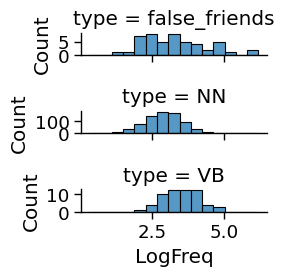

In [102]:
sns.displot(data=expt_word_freqs.reset_index(), x="LogFreq", row="type", kind="hist", bins=15,
            height=1, aspect=3, facet_kws={"sharey": False})

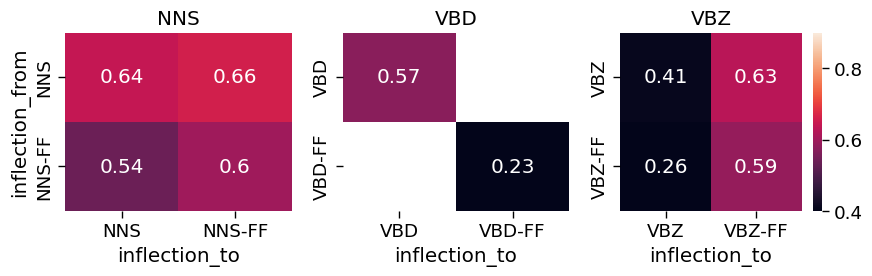

In [105]:
focus_ff_results = all_ff_results.query("base_model_name == @focus_base_model and model_name == @focus_model and equivalence == @focus_equivalence")

ff_results_summary2 = focus_ff_results.groupby(["inflection_from", "inflection_to"]) \
    [["correct", "gt_label_rank", "gt_distance"]].mean().reset_index()

ff_results_summary2["transfer_label"] = ff_results_summary2.inflection_from + " -> " + ff_results_summary2.inflection_to

# add in data for NNS->NNS and VBZ->VBZ
ff_results_summary2 = pd.concat([
    ff_results_summary2,
    nnvb_results_summary2.query("inflection_from == inflection_to and model_label == 'Word'"),
    vbd_results_summary2.query("inflection_from == inflection_to and model_label == 'Word'")], axis=0)

ff_results_summary2["base_inflection"] = ff_results_summary2.inflection_from.str.replace("-FF", "")

ff_results_summary2 = ff_results_summary2[ff_results_summary2.base_inflection.isin(plot_inflections)]
ff_results_summary2 = ff_results_summary2.astype({"correct": float})

g = sns.FacetGrid(ff_results_summary2, col="base_inflection", sharex=False, sharey=False)

def mapfn(data, **kwargs):
    ax = plt.gca()
    sns.heatmap(data.set_index(["inflection_from", "inflection_to"]).correct.unstack("inflection_to"),
                vmin=main_plot_vmin, vmax=main_plot_vmax, annot=True, ax=ax)

g.map_dataframe(mapfn)

for i, ax in enumerate(g.axes.flat):
    ax.set_title(ax.get_title().replace("base_inflection = ", ""))
    if i > 0:
        ax.set_ylabel("")
    if i < len(g.axes.flat) - 1:
        ax.collections[0].colorbar.remove()

g.fig.tight_layout()
g.fig.savefig(f"{output_dir}/ff_results.pdf")

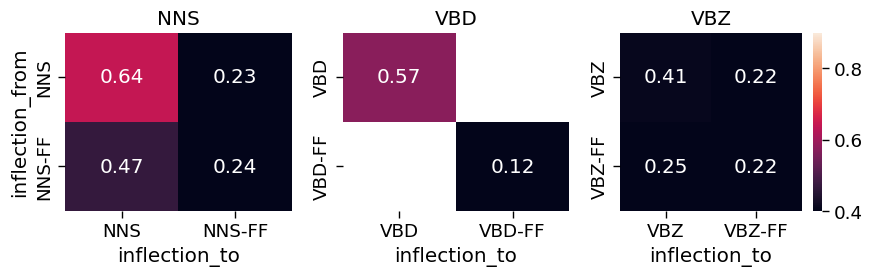

In [107]:
focus_weak_ff_results = weak_ff_results.query("base_model_name == @focus_base_model and model_name == @focus_model and equivalence == @focus_equivalence")

weak_ff_results_summary2 = focus_weak_ff_results.groupby(["inflection_from", "inflection_to"]) \
    [["correct", "gt_label_rank", "gt_distance"]].mean().reset_index()

weak_ff_results_summary2["transfer_label"] = weak_ff_results_summary2.inflection_from + " -> " + weak_ff_results_summary2.inflection_to

# add in data for NNS->NNS and VBZ->VBZ
weak_ff_results_summary2 = pd.concat([weak_ff_results_summary2, nnvb_results_summary2.query("inflection_from == inflection_to and model_label == 'Word'")], axis=0)
# add in data for VBD->VBD
weak_ff_results_summary2 = pd.concat([weak_ff_results_summary2, vbd_results_summary2.query("inflection_from == inflection_to and model_label == 'Word'")], axis=0)

weak_ff_results_summary2["base_inflection"] = weak_ff_results_summary2.inflection_from.str.replace("-FF", "")

weak_ff_results_summary2 = weak_ff_results_summary2[weak_ff_results_summary2.base_inflection.isin(plot_inflections)]
weak_ff_results_summary2 = weak_ff_results_summary2.astype({"correct": float})

g = sns.FacetGrid(weak_ff_results_summary2, col="base_inflection", sharex=False, sharey=False)

def mapfn(data, **kwargs):
    ax = plt.gca()
    sns.heatmap(data.set_index(["inflection_from", "inflection_to"]).correct.unstack("inflection_to"),
                vmin=main_plot_vmin, vmax=main_plot_vmax, annot=True, ax=ax)

g.map_dataframe(mapfn)

for i, ax in enumerate(g.axes.flat):
    ax.set_title(ax.get_title().replace("base_inflection = ", ""))
    if i > 0:
        ax.set_ylabel("")
    if i < len(g.axes.flat) - 1:
        ax.collections[0].colorbar.remove()

g.fig.tight_layout()
g.fig.savefig(f"{output_dir}/ff_results_weak.pdf")

### Frequency analysis

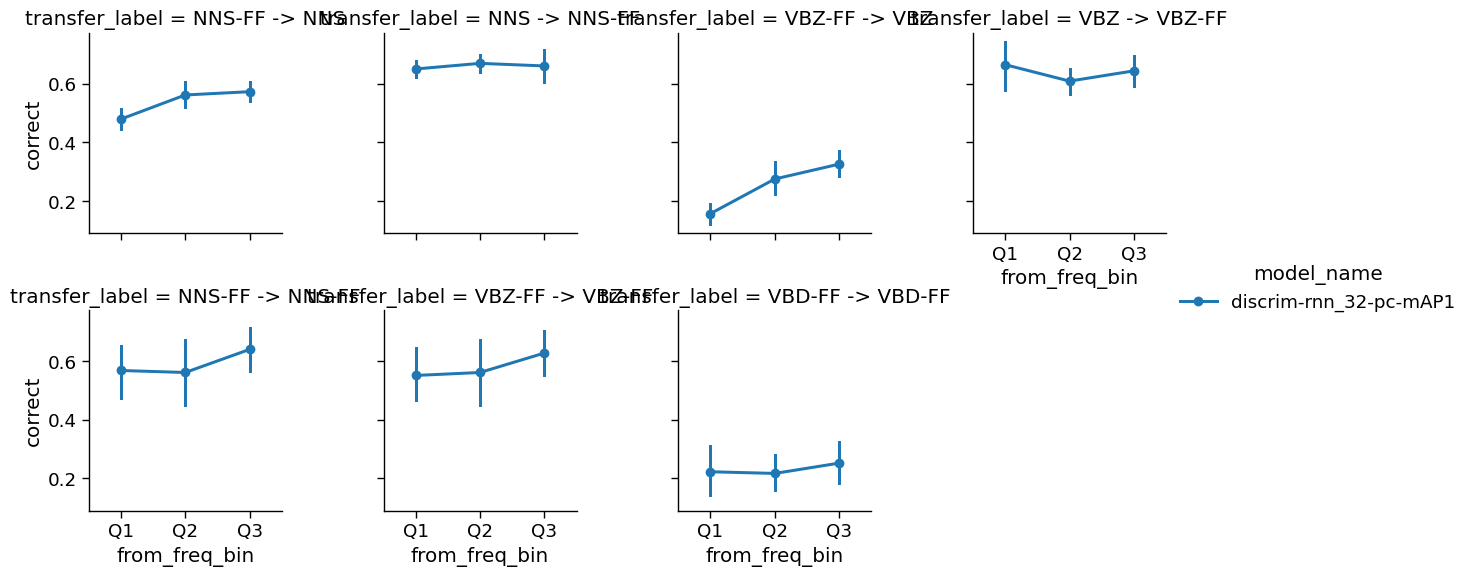

In [108]:
sns.catplot(data=all_ff_results.query("base_model_name == 'w2v2_pc_8'").reset_index(),
            x="from_freq_bin", y="correct", hue="model_name",
            col="transfer_label", col_wrap=4, kind="point", height=3)

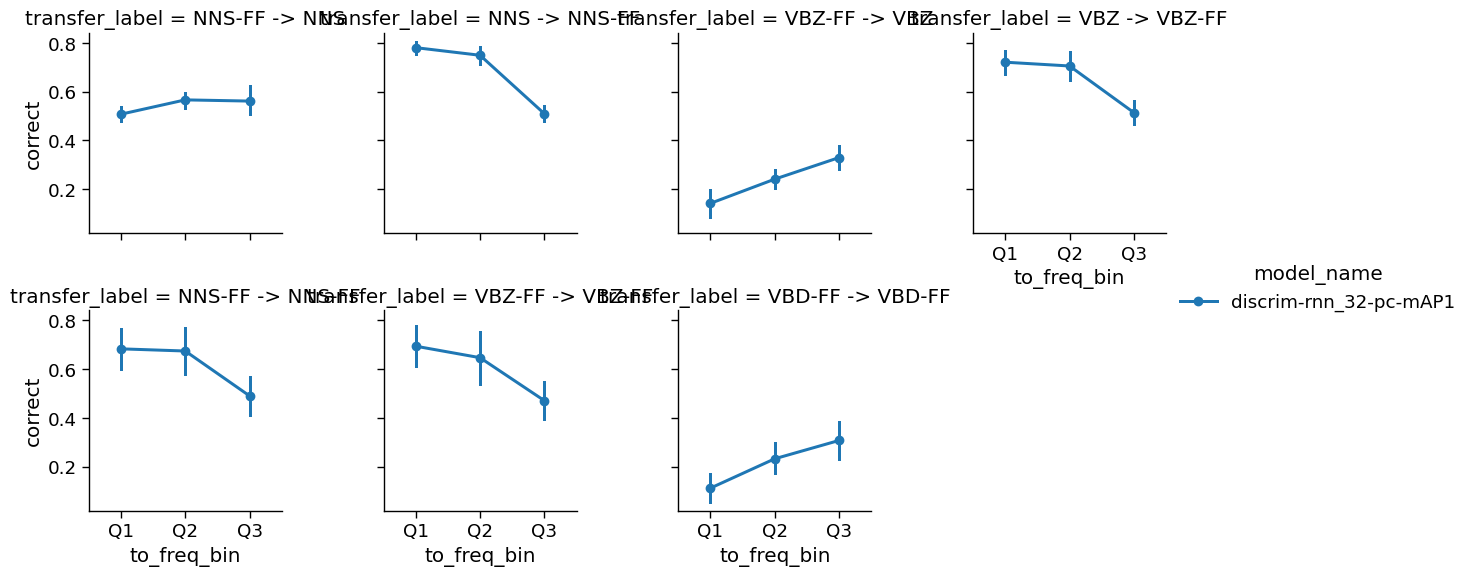

In [109]:
sns.catplot(data=all_ff_results.query("base_model_name == 'w2v2_pc_8'").reset_index(),
            x="to_freq_bin", y="correct", hue="model_name",
            col="transfer_label", col_wrap=4, kind="point", height=3)

## Forced-choice analysis

In [110]:
state_space = StateSpaceAnalysisSpec.from_hdf5(state_space_path)

/scratch/jgauthier/transformers/lib/python3.10/site-packages/tables/attributeset.py:295: DataTypeWarning: Unsupported type for attribute 'labels_are_repr' in node '/'. Offending HDF5 class: 8
  value = self._g_getattr(self._v_node, name)


In [111]:
cuts_df = state_space.cuts.xs("phoneme", level="level").drop(columns=["onset_frame_idx", "offset_frame_idx"])
cuts_df["label_idx"] = cuts_df.index.get_level_values("label").map({l: i for i, l in enumerate(state_space.labels)})
cuts_df["frame_idx"] = cuts_df.groupby(["label", "instance_idx"]).cumcount()
cuts_df = cuts_df.reset_index().set_index(["label", "instance_idx", "frame_idx"]).sort_index()
cut_phonemic_forms = cuts_df.groupby(["label", "instance_idx"]).description.agg(' '.join)

In [112]:
fc_exclude = "ba c des eh p k pa ca na b co ben been shun own".split()
fc_exclude_inflected = "look'd push'd los ince".split()

In [113]:
fc_results = all_results.loc[all_results.inflection_to.str.startswith("FC-")].copy()
fc_results = fc_results[~fc_results.base_to.isin(fc_exclude)]
fc_results["fc_pair"] = fc_results.inflection_to.str.extract(r"FC-([\w\s_]+)")
fc_results["inflected_from"] = fc_results.from_equiv_label.apply(lambda x: eval(x)[1])
fc_results["inflected_to"] = fc_results.to_equiv_label.apply(lambda x: eval(x)[1])
fc_results = fc_results[~fc_results.inflected_to.isin(fc_exclude_inflected)]

In [114]:
fc_metadata = all_cross_instances[all_cross_instances.inflection.str.startswith("FC-")] \
    .groupby(["inflection", "base", "inflected"]).head(1) \
        [["inflection", "base", "inflected", "inflected2", "strong", "post_divergence"]] \
    .rename(columns={"base": "base_to", "inflected": "inflected_to", "inflected2": "inflected2_to",
                     "strong": "strong_to", "post_divergence": "post_divergence_to"})
fc_metadata["fc_pair"] = fc_metadata.inflection.str.extract(r"FC-([\w\s_]+)")
fc_metadata = fc_metadata.drop(columns=["inflection"])

In [115]:
fc_results = pd.merge(fc_results, fc_metadata, on=["fc_pair", "base_to", "inflected_to"])

In [116]:
# merge in metadata about "from" item
fc_from_metadata = all_cross_instances[all_cross_instances.inflection.isin(fc_results.inflection_from)] \
    .groupby(["inflection", "base", "inflected"]).apply(lambda xs: xs.post_divergence.value_counts().index[0]) \
    .rename("post_divergence") \
    .reset_index() \
    .rename(columns={"inflection": "inflection_from", "base": "base_from", "inflected": "inflected_from", "post_divergence": "post_divergence_from"})

fc_results = pd.merge(fc_results, fc_from_metadata, on=["inflection_from", "base_from", "inflected_from"])

/tmp/ipykernel_1575562/3703868743.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .groupby(["inflection", "base", "inflected"]).apply(lambda xs: xs.post_divergence.value_counts().index[0]) \


In [117]:
# keep only the most frequent suffixes
keep_post_divergence_n = 4
keep_post_divergence = fc_results.groupby("fc_pair").apply(lambda xs: xs.post_divergence_from.value_counts().head(keep_post_divergence_n))
fc_results = pd.concat([
    fc_results[(fc_results.fc_pair == fc_pair) & fc_results.post_divergence_from.isin(rows.index.get_level_values("post_divergence_from"))]
    for fc_pair, rows in keep_post_divergence.groupby("fc_pair")
])

/tmp/ipykernel_1575562/1799241224.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  keep_post_divergence = fc_results.groupby("fc_pair").apply(lambda xs: xs.post_divergence_from.value_counts().head(keep_post_divergence_n))


In [118]:
strong_items = fc_results.groupby(["fc_pair", "base_to"]).apply(
    lambda xs: xs.inflected_to.head(1) if xs.strong_to.iloc[0] == True else xs.inflected2_to.head(1)).droplevel(-1)
weak_items = fc_results.groupby(["fc_pair", "base_to"]).apply(
    lambda xs: xs.inflected_to.head(1) if xs.strong_to.iloc[0] == False else xs.inflected2_to.head(1)).droplevel(-1)

/tmp/ipykernel_1575562/3321713623.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  strong_items = fc_results.groupby(["fc_pair", "base_to"]).apply(
/tmp/ipykernel_1575562/3321713623.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weak_items = fc_results.groupby(["fc_pair", "base_to"]).apply(


In [119]:
import functools
import itertools


@functools.lru_cache(maxsize=None)
def _get_strong_items(fc_pair, base_to):
    item_source = strong_items
    try:
        item = item_source[fc_pair, base_to]
    except KeyError:
        return None

    # find all homophones of the item
    homophones = set(itertools.chain.from_iterable(
        cut_phonemic_forms[cut_phonemic_forms == form].index.get_level_values("label").unique()
        for form in set(cut_phonemic_forms.loc[item])
    ))
    return " ".join(homophones)
@functools.lru_cache(maxsize=None)
def _get_weak_items(fc_pair, base_to):
    item_source = weak_items
    try:
        item = item_source[fc_pair, base_to]
    except KeyError:
        return None

    # find all homophones of the item
    homophones = set(itertools.chain.from_iterable(
        cut_phonemic_forms[cut_phonemic_forms == form].index.get_level_values("label").unique()
        for form in set(cut_phonemic_forms.loc[item])
    ))
    return " ".join(homophones)
    
def get_strong_items(ser):
    fc_pair, base_to = tuple(ser)
    return _get_strong_items(fc_pair, base_to)
def get_weak_items(ser):
    fc_pair, base_to = tuple(ser)
    return _get_weak_items(fc_pair, base_to)
fc_results["strong_item_to"] = fc_results[["fc_pair", "base_to"]].apply(get_strong_items, axis=1)
fc_results["weak_item_to"] = fc_results[["fc_pair", "base_to"]].apply(get_weak_items, axis=1)

In [120]:
fc_results["chose_strong"] = fc_results.apply(lambda xs: (re.search(f"\\b{xs.predicted_label}\\b", xs.strong_item_to) is not None) if xs.strong_item_to is not None else None, axis=1)
fc_results["chose_weak"] = fc_results.apply(lambda xs: (re.search(f"\\b{xs.predicted_label}\\b", xs.weak_item_to) is not None) if xs.weak_item_to is not None else None, axis=1)
fc_results["chose_strong_or_weak"] = fc_results.chose_strong.fillna(False) | fc_results.chose_weak.fillna(False)

In [121]:
fc_results.groupby("fc_pair").sample(5)[["fc_pair", "base_from", "inflected_from", "base_to", "inflected_to", "predicted_label", "strong_item_to", "chose_strong", "chose_weak"]]

,fc_pair,base_from,inflected_from,base_to,inflected_to,predicted_label,strong_item_to,chose_strong,chose_weak
9904,D_IH D,grip,gripped,plan,planned,plants,planned,False,False
8891,D_IH D,support,supported,plan,planned,plain,planned,False,False
9730,D_IH D,wash,washed,plan,planned,plans,planned,False,False
8355,D_IH D,crown,crowned,pain,pained,panting,pained,False,False
9475,D_IH D,harness,harnessed,juan,wand,wand,wand,True,False
6921,D_T,kiss,kissed,bough,bowed,boughs,bowed,False,False
6224,D_T,dart,darted,play,play'd,playing,play'd played,False,False
7102,D_T,dwell,dwelt,spoil,spoiled,spoilt,spoiled,False,True
6829,D_T,convince,convinced,ray,raid,raised,raid rayed,False,False
5738,D_T,encounter,encountered,a,aid,ayrton,aide aid,False,False


In [122]:
fc_results.groupby(["fc_pair", "post_divergence_from", "strong_to", "base_to"]).chose_strong.mean().dropna().sort_values()

fc_pair  post_divergence_from  strong_to  base_to
Z_S      AH Z                  True       hen        0.0
T_IH D   T                     False      flew       0.0
                                          juan       0.0
                                          pain       0.0
                                          plan       0.0
                                                    ... 
D_T      IH D                  True       spoil      1.0
         AH D                  True       ally       1.0
                                          burn       1.0
Z_S      S                     True       her        1.0
         Z                     True       river      1.0
Name: chose_strong, Length: 421, dtype: float64

/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/scratch/jgauthier/

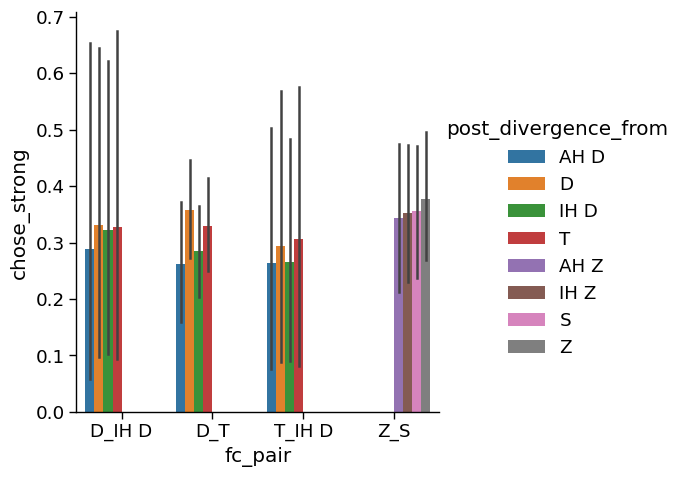

In [123]:
sns.catplot(data=fc_results.groupby(["fc_pair", "post_divergence_from", "base_to"]).chose_strong.mean().dropna().reset_index(),
            x="fc_pair", hue="post_divergence_from", y="chose_strong", kind="bar")

In [237]:
# fc_results.query("base_to == 'juan'").groupby("fc_pair").apply(lambda xs: xs.predicted_label.value_counts().head(10))

/tmp/ipykernel_1575562/1362019733.py:3: RuntimeWarning: invalid value encountered in scalar divide
  "chose_strong_norm": xs.chose_strong.sum() / xs.chose_strong_or_weak.sum(),
/tmp/ipykernel_1575562/1362019733.py:4: RuntimeWarning: invalid value encountered in scalar divide
  "chose_weak_norm": xs.chose_weak.sum() / xs.chose_strong_or_weak.sum()
/tmp/ipykernel_1575562/1362019733.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fc_results_by_word = fc_results.groupby(["fc_pair", "base_to"]).apply(


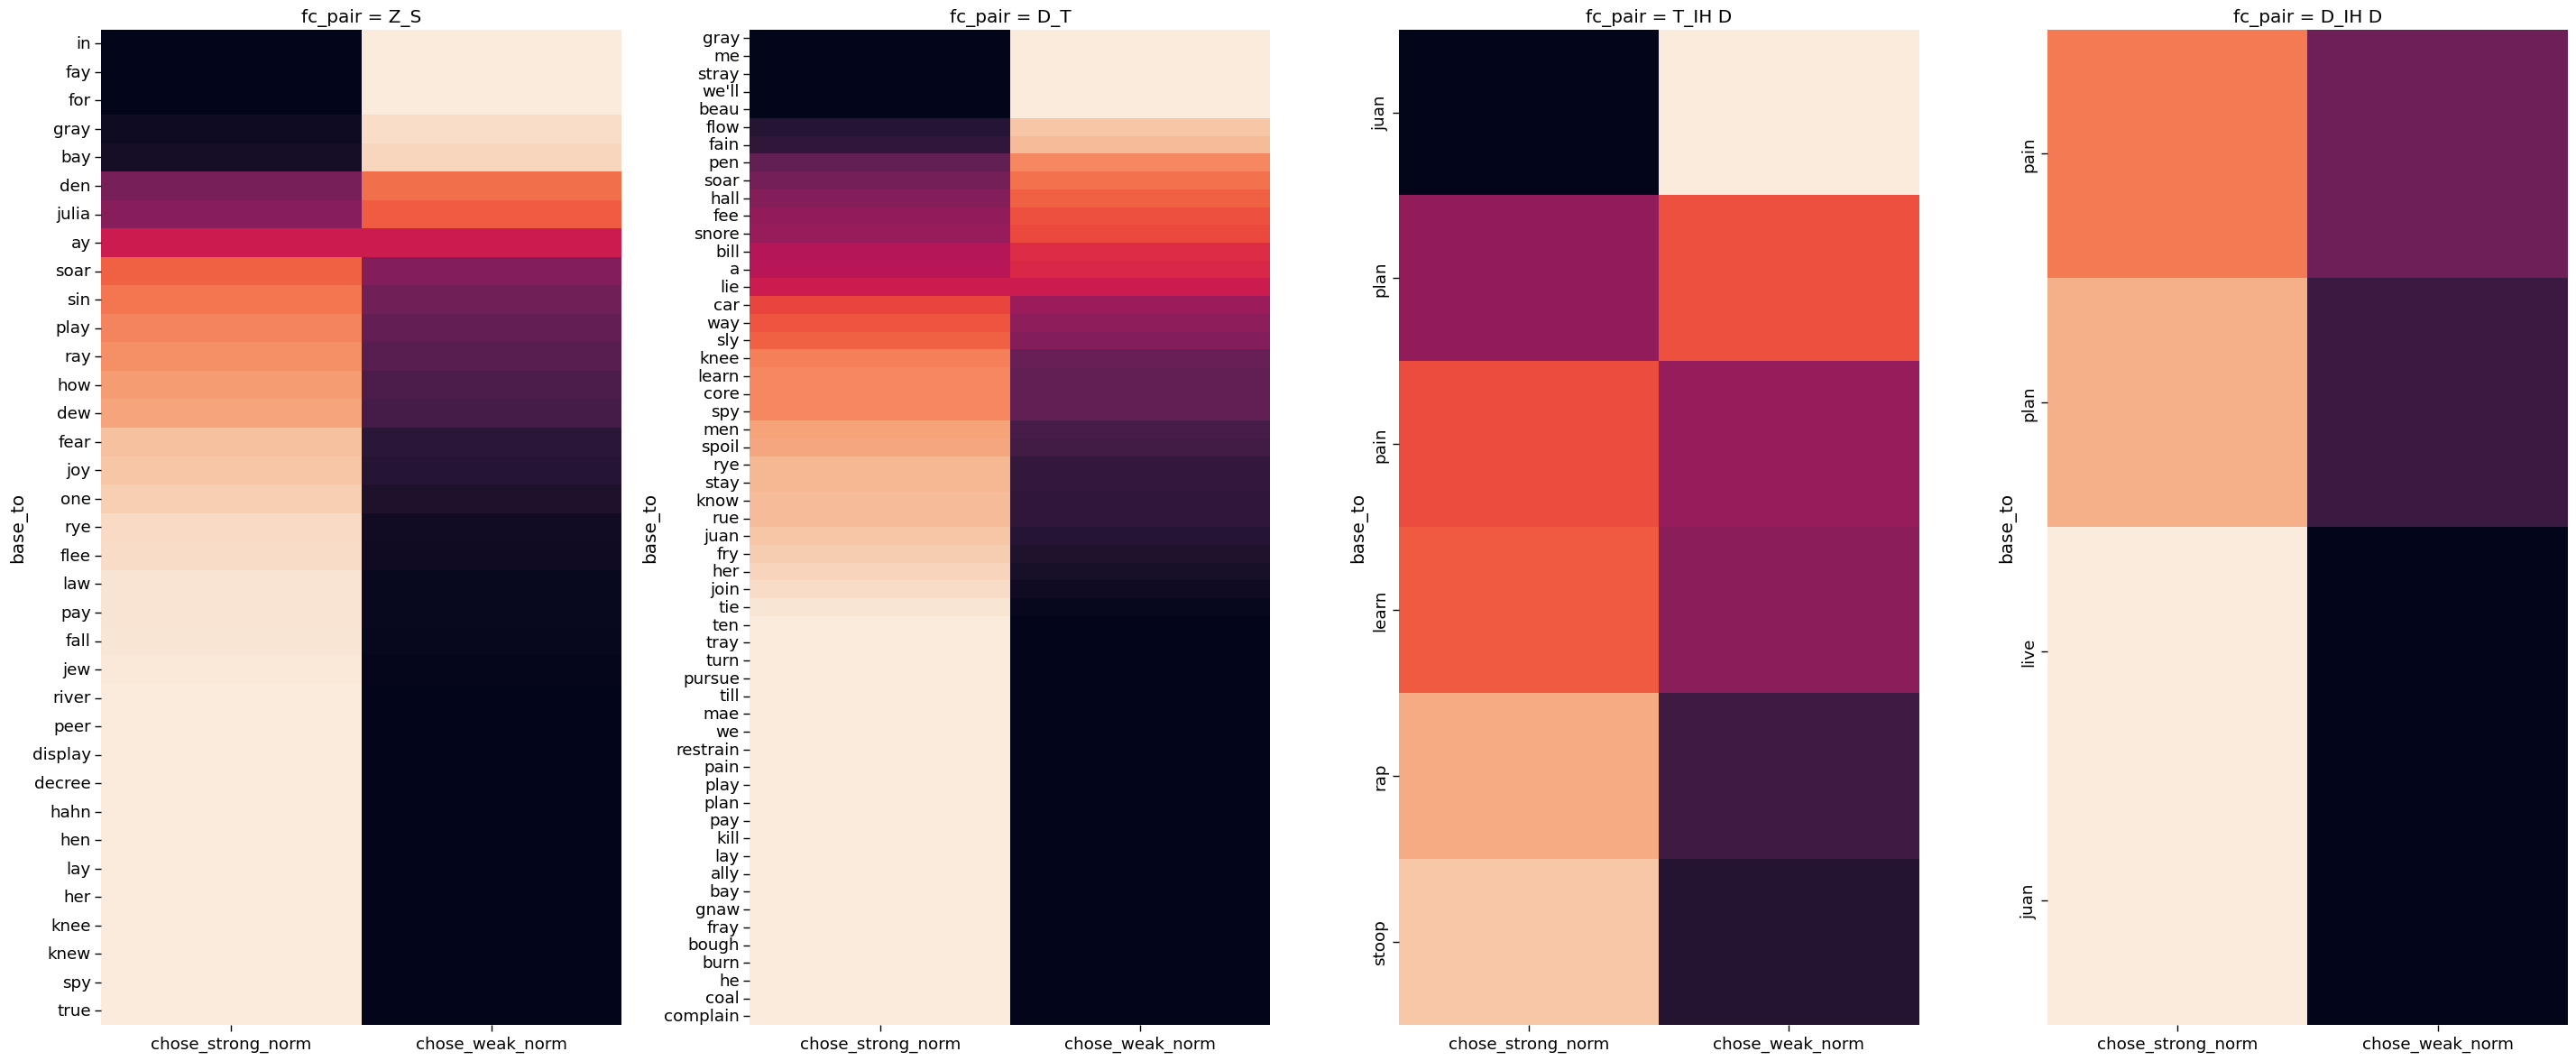

In [124]:
fc_results_by_word = fc_results.groupby(["fc_pair", "base_to"]).apply(
    lambda xs: pd.Series({
        "chose_strong_norm": xs.chose_strong.sum() / xs.chose_strong_or_weak.sum(),
        "chose_weak_norm": xs.chose_weak.sum() / xs.chose_strong_or_weak.sum()
    })) \
    .dropna().reset_index().sort_values("chose_strong_norm")

g = sns.FacetGrid(data=fc_results_by_word, col="fc_pair", col_wrap=4, height=12, aspect=0.6, sharey=False)
def f(data, **kwargs):
    sns.heatmap(data=data.set_index("base_to")[["chose_strong_norm", "chose_weak_norm"]],
                vmin=0, vmax=1, cbar=False, **kwargs)
g.map_dataframe(f)

/tmp/ipykernel_1575562/642176507.py:3: RuntimeWarning: invalid value encountered in scalar divide
  "chose_strong_norm": xs.chose_strong.sum() / xs.chose_strong_or_weak.sum(),
/tmp/ipykernel_1575562/642176507.py:4: RuntimeWarning: invalid value encountered in scalar divide
  "chose_weak_norm": xs.chose_weak.sum() / xs.chose_strong_or_weak.sum()
/tmp/ipykernel_1575562/642176507.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  fc_results_by_word_and_source = fc_results.groupby(["fc_pair", "post_divergence_from", "base_to"]).apply(
/scratch/jgauthier/transformers/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a leng

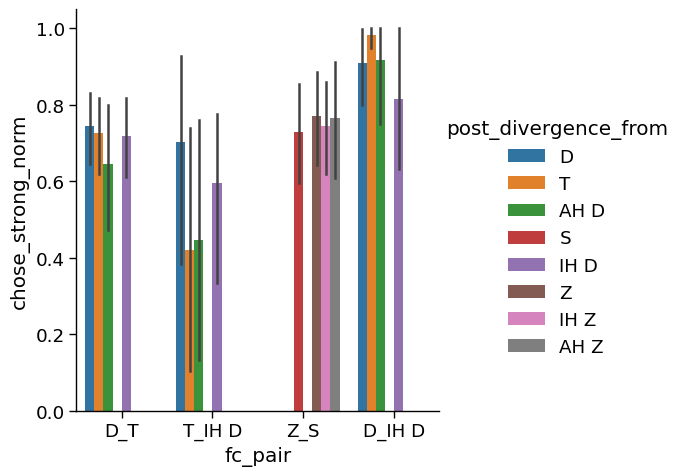

In [125]:
fc_results_by_word_and_source = fc_results.groupby(["fc_pair", "post_divergence_from", "base_to"]).apply(
    lambda xs: pd.Series({
        "chose_strong_norm": xs.chose_strong.sum() / xs.chose_strong_or_weak.sum(),
        "chose_weak_norm": xs.chose_weak.sum() / xs.chose_strong_or_weak.sum()
    })) \
    .dropna().reset_index().sort_values("chose_strong_norm")

sns.catplot(data=fc_results_by_word_and_source,
            x="fc_pair", hue="post_divergence_from", y="chose_strong_norm", kind="bar")

### Frequency analysis

In [ ]:
fc_results = pd.merge(fc_results, word_freq_df.LogFreq.rename("from_base_freq"),
                            left_on="base_from", right_index=True)
fc_results = pd.merge(fc_results, word_freq_df.LogFreq.rename("from_inflected_freq"),
                            left_on="inflected_from", right_index=True)
fc_results = pd.merge(fc_results, word_freq_df.LogFreq.rename("to_base_freq"),
                              left_on="base_to", right_index=True)
fc_results = pd.merge(fc_results, word_freq_df.LogFreq.rename("to_inflected_freq"),
                            left_on="inflected_to", right_index=True)

In [250]:
fc_results["from_freq"] = fc_results[["from_base_freq", "from_inflected_freq"]].mean(axis=1)
fc_results["to_freq"] = fc_results[["to_base_freq", "to_inflected_freq"]].mean(axis=1)

_, fc_frequency_bins = pd.qcut(pd.concat([fc_results.to_freq, fc_results.from_freq]), q=4, retbins=True)
fc_results["from_freq_bin"] = pd.cut(fc_results.from_freq, bins=fc_frequency_bins, labels=[f"Q{i}" for i in range(1, 5)])
fc_results["to_freq_bin"] = pd.cut(fc_results.to_freq, bins=fc_frequency_bins, labels=[f"Q{i}" for i in range(1, 5)])

/tmp/ipykernel_1332361/2828727962.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.catplot(data=fc_results.groupby(["fc_pair", "post_divergence_from", "base_to", "from_freq_bin"]).apply(
/tmp/ipykernel_1332361/2828727962.py:3: RuntimeWarning: invalid value encountered in scalar divide
  "chose_strong_norm": xs.chose_strong.sum() / xs.chose_strong_or_weak.sum(),
/tmp/ipykernel_1332361/2828727962.py:4: RuntimeWarning: invalid value encountered in scalar divide
  "chose_weak_norm": xs.chose_weak.sum() / xs.chose_strong_or_weak.sum()
/tmp/ipykernel_1332361/2828727962.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups

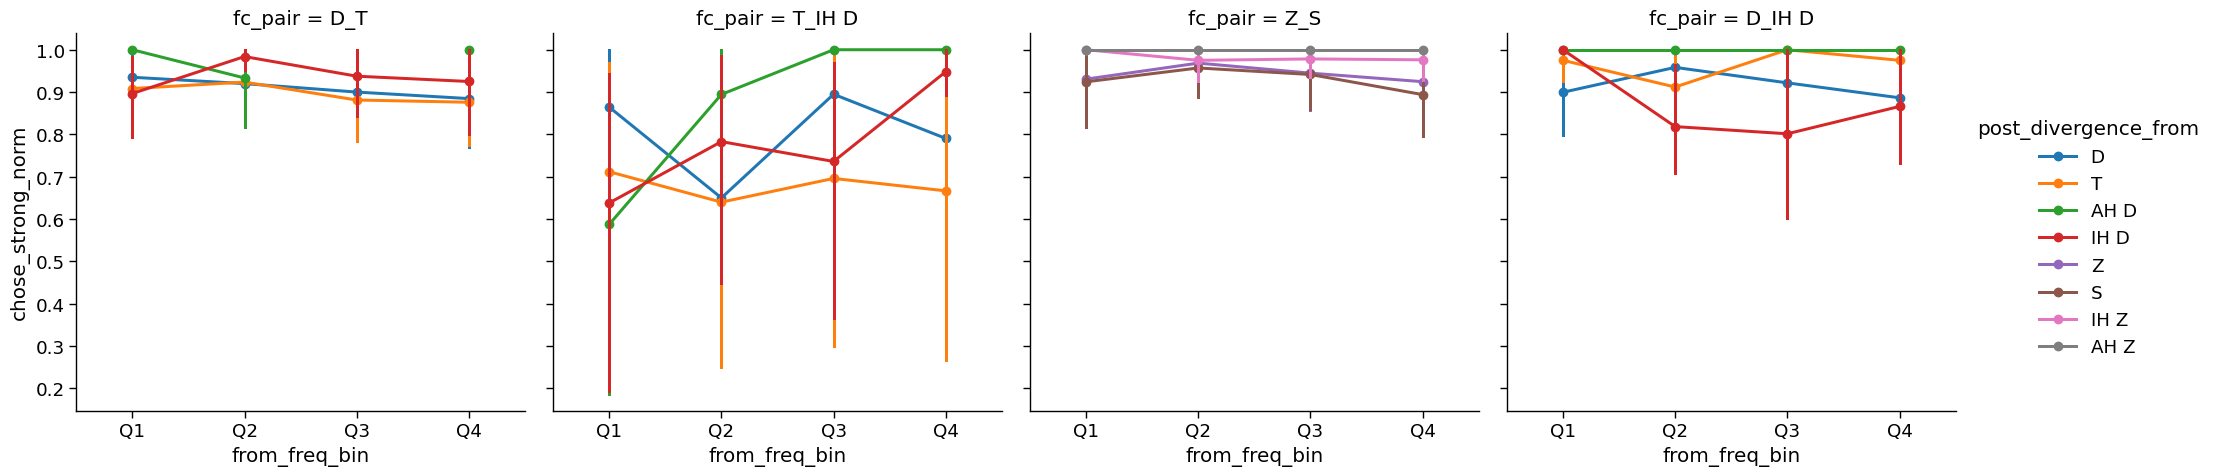

In [255]:
sns.catplot(data=fc_results.groupby(["fc_pair", "post_divergence_from", "base_to", "from_freq_bin"]).apply(
    lambda xs: pd.Series({
        "chose_strong_norm": xs.chose_strong.sum() / xs.chose_strong_or_weak.sum(),
        "chose_weak_norm": xs.chose_weak.sum() / xs.chose_strong_or_weak.sum()
    })) \
    .dropna().reset_index().sort_values("chose_strong_norm"),
    x="from_freq_bin", y="chose_strong_norm", hue="post_divergence_from", col="fc_pair", kind="point")

/tmp/ipykernel_1332361/552877900.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.catplot(data=fc_results.groupby(["fc_pair", "post_divergence_from", "base_to", "to_freq_bin"]).apply(
/tmp/ipykernel_1332361/552877900.py:3: RuntimeWarning: invalid value encountered in scalar divide
  "chose_strong_norm": xs.chose_strong.sum() / xs.chose_strong_or_weak.sum(),
/tmp/ipykernel_1332361/552877900.py:4: RuntimeWarning: invalid value encountered in scalar divide
  "chose_weak_norm": xs.chose_weak.sum() / xs.chose_strong_or_weak.sum()
/tmp/ipykernel_1332361/552877900.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False

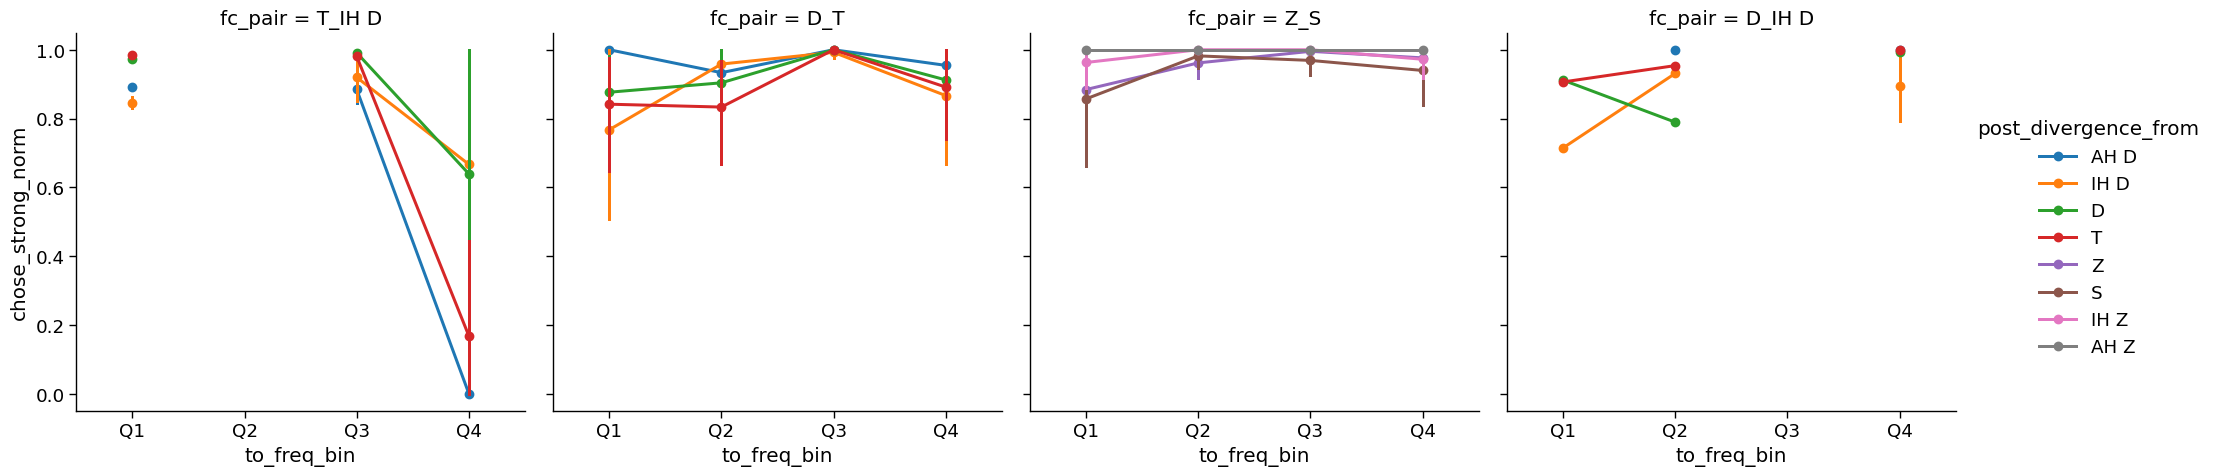

In [256]:
sns.catplot(data=fc_results.groupby(["fc_pair", "post_divergence_from", "base_to", "to_freq_bin"]).apply(
    lambda xs: pd.Series({
        "chose_strong_norm": xs.chose_strong.sum() / xs.chose_strong_or_weak.sum(),
        "chose_weak_norm": xs.chose_weak.sum() / xs.chose_strong_or_weak.sum()
    })) \
    .dropna().reset_index().sort_values("chose_strong_norm"),
    x="to_freq_bin", y="chose_strong_norm", hue="post_divergence_from",  col="fc_pair", kind="point")